# Credits

**This notebook is a fork of [the original notebook](https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series), hence all credits to the original author ([SIDDHARTH YADAV ](https://www.kaggle.com/thebrownviking20/) aka [@thebrownviking20](https://www.kaggle.com/thebrownviking20/)). Hence most of the content from the original author is preserved and in the same person as that written originally - great work and an inspiration to all.**

# Why this notebook

I noticed a few opportunities to improve the content and hence I'm forking it with the improvisations. A summary of the changes you will notice in this notebook as compared to [the original one]((https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series):
- Using stocks data for all the examples, instead of a mix of stocks and humidity/pressure data
- Showing this using cryptocurrencies like [BTC](https://www.coingecko.com/en/coins/bitcoin) and [ETH](https://www.coingecko.com/en/coins/ethereum)
- Using an additional stocks and cryptocurrencies dataset
- Made the comparisons between the two cryptocurrencies uniform across the notebook
- Minor tweaks to fix data and visualisation issues
- Shrink large datasets, load only sample of the full dataset using [dtype_diet](https://github.com/ianozsvald/dtype_diet) and subsetting datasets
- Notebook updated regularly to reflect latest prices of the coins

# Related notebooks

- **[The original notebook](https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series)**
- **[Everything you can do with a time series (stocks)](https://www.kaggle.com/neomatrix369/everything-you-can-do-with-a-time-series-stocks)**
- **[Everything you can do with a time series (metals)](https://www.kaggle.com/neomatrix369/everything-you-can-do-with-a-time-series-metals)**

# Aim
Since my first week on this platform, I have been fascinated by the topic of **time series analysis.** This kernel is prepared to be a container of many broad topics in the field of time series analysis. My motive is to make this the ultimate reference to time series analysis for beginners and experienced people alike.

# Some important things
1. This kernel **is a work in progress so every time you see on your home feed and open it, you will surely find fresh content.**
2. I am doing this only after completing various courses in this field. I continue to study more advanced concepts to provide more knowledge and content.
3. If there is any suggestion or any specific topic you would like me to cover, kindly mention that in the comments.
4. **If you like my work, be sure to upvote** (press the like button) this kernel so it looks more relevant and meaningful to the community.

In [1]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

rcParams['figure.figsize'] = 11, 9

from datetime import datetime, timedelta
import gc

print(os.listdir("../input"))

['stock-time-series-20050101-to-20171231', 'g-research-crypto-forecasting', 'price-volume-data-for-all-us-stocks-etfs', 'the-winton-stock-market-challenge']


In [2]:
%%bash
# https://pypi.org/project/yahoofinancials/
pip install yahoofinancials

  Running setup.py bdist_wheel for yahoofinancials: started
  Running setup.py bdist_wheel for yahoofinancials: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/d9/7e/cf/4977a8572d5247242a4b13018d1d36923024ba84236e0d28bc
Successfully built yahoofinancials


tensorflow 1.9.0rc0 has requirement setuptools<=39.1.0, but you'll have setuptools 40.0.0 which is incompatible.
kmodes 0.9 has requirement scikit-learn<0.20.0,>=0.19.0, but you'll have scikit-learn 0.20.dev0 which is incompatible.
kmeans-smote 0.1.0 has requirement imbalanced-learn<0.4,>=0.3.1, but you'll have imbalanced-learn 0.4.0.dev0 which is incompatible.
kmeans-smote 0.1.0 has requirement scikit-learn<0.20,>=0.19.0, but you'll have scikit-learn 0.20.dev0 which is incompatible.
hep-ml 0.5.0 has requirement theano==0.8.2, but you'll have theano 1.0.2 which is incompatible.
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.0 which is incompatible.
You are using pip version 10.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from yahoofinancials import YahooFinancials
from joblib import Memory

TMPDIR = '/tmp'
memory = Memory(TMPDIR, verbose=0)

In [4]:
@memory.cache
def get_ticker_data(ticker: str, param_start_date, param_end_date) -> dict:
    raw_data = YahooFinancials(ticker)
    return raw_data.get_historical_price_data(param_start_date, param_end_date, "daily").copy()

def fetch_ticker_data(ticker: str, start_date, end_date) -> pd.DataFrame:
    date_range = pd.bdate_range(start=start_date, end=end_date)
    values = pd.DataFrame({'Date': date_range})
    values['Date'] = pd.to_datetime(values['Date'])
    raw_data = get_ticker_data(ticker, start_date, end_date)
    return pd.DataFrame(raw_data[ticker]["prices"])[['date', 'open', 'high', 'low', 'adjclose', 'volume']]    

- <a href='#1'>1. Introduction to date and time</a>
    - <a href='#1.1'>1.1 Importing time series data</a>
    - <a href='#1.2'>1.2 Cleaning and preparing time series data</a>
    - <a href='#1.3'>1.3 Visualizing the datasets</a>
    - <a href='#1.4'>1.4 Timestamps and Periods</a>
    - <a href='#1.5'>1.5 Using date_range</a>
    - <a href='#1.6'>1.6 Using to_datetime</a>
    - <a href='#1.7'>1.7 Shifting and lags</a>
    - <a href='#1.8'>1.8 Resampling</a>
- <a href='#2'>2. Finance and Statistics</a>
    - <a href='#2.1'>2.1 Percent change</a>
    - <a href='#2.2'>2.2 Daily returns</a>
    - <a href='#2.3'>2.3 Absolute change in successive rows</a>
    - <a href='#2.4'>2.4 Comparing two or more time series</a>
    - <a href='#2.5'>2.5 Window functions</a>
    - <a href='#2.6'>2.6 OHLC charts</a>
    - <a href='#2.7'>2.7 Candlestick charts</a>
    - <a href='#2.8'>2.8 Autocorrelation and Partial Autocorrelation</a>
- <a href='#3'>3. Time series decomposition and Random Walks</a>
    - <a href='#3.1'>3.1 Trends, Seasonality and Noise</a>
    - <a href='#3.2'>3.2 White Noise</a>
    - <a href='#3.3'>3.3 Random Walk</a>
    - <a href='#3.4'>3.4 Stationarity</a>
- <a href='#4'>4. Modelling using statsmodels</a>
    - <a href='#4.1'>4.1 AR models</a>
    - <a href='#4.2'>4.2 MA models</a>
    - <a href='#4.3'>4.3 ARMA models</a>
    - <a href='#4.4'>4.4 ARIMA models</a>
    - <a href='#4.5'>4.5 VAR models</a>
    - <a href='#4.6'>4.6 State space methods</a>
        - <a href='#4.6.1'>4.6.1 SARIMA models</a>
        - <a href='#4.6.2'>4.6.2 Unobserved components</a>
        - <a href='#4.6.3'>4.6.3 Dynamic Factor models</a>

# <a id='1'>1. Introduction to date and time</a>

## <a id='1.1'>1.1 Importing time series data</a>

### How to import data?
First, we import all the datasets needed for this kernel. The required time series column is imported as a datetime column using **parse_dates** parameter and is also selected as index of the dataframe using **index_col** parameter. 
#### Data being used:-
1. Bitcoin Cryptocurrency Data
2. Ethereum Cryptocurrency Data

In [5]:
DATASET_SOURCE = 'LIVE' # or 'COMPETITION_DATASET'

In [6]:
%%bash
rm -f dtype_diet.py
wget https://raw.githubusercontent.com/ianozsvald/dtype_diet/master/dtype_diet.py

--2022-02-02 08:43:36--  https://raw.githubusercontent.com/ianozsvald/dtype_diet/master/dtype_diet.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3906 (3.8K) [text/plain]
Saving to: ‘dtype_diet.py’

     0K ...                                                   100% 16.2M=0s

2022-02-02 08:43:36 (16.2 MB/s) - ‘dtype_diet.py’ saved [3906/3906]



In [7]:
import dtype_diet

In [8]:
%%time
if DATASET_SOURCE == 'LIVE':
    pass # do othing
else:
    cryptocurrencies = pd.read_csv('../input/g-research-crypto-forecasting/train.csv')
    display(cryptocurrencies.info(memory_usage="deep"))
    dtype_diet.report_on_dataframe(cryptocurrencies)
    cryptocurrencies['timestamp'] = cryptocurrencies['timestamp'].astype(np.int32)
    cryptocurrencies['Asset_ID'] = cryptocurrencies['Asset_ID'].astype(np.int8)
    cryptocurrencies['Count'] = cryptocurrencies['Count'].astype(np.float32)
    display(cryptocurrencies.info(memory_usage="deep"))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.54 µs


In [9]:
def extract_single_coin(source_dataset: pd.DataFrame, asset_id: int = 1, frequency: str = "D") -> pd.DataFrame:
    filter_coin = source_dataset['Asset_ID'] == asset_id
    coin_full = source_dataset[filter_coin].sort_values(by='timestamp').copy()
    coin_full['DateTime'] = coin_full['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
    coin_full = coin_full.set_index('DateTime')
    coin_full = coin_full.asfreq(frequency).interpolate().copy()
    display(coin_full.info())
    display(coin_full.head())
    coin = coin_full.copy()
    return coin_full, coin

In [10]:
start_date = (datetime.now() - timedelta(days=365*3)).strftime("%Y-%m-%d")
end_date = datetime.now().strftime("%Y-%m-%d")

In [11]:
%%time
if DATASET_SOURCE == 'LIVE':
    btc_full = fetch_ticker_data('BTC-USD', start_date, end_date)
    btc_full.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
    btc_full['DateTime'] = btc_full['DateTime'].apply(lambda x: datetime.fromtimestamp(x))
    btc_full = btc_full.fillna(method="ffill", axis=0)
    btc_full = btc_full.fillna(method="bfill", axis=0)
    btc_full = btc_full.set_index('DateTime')
    btc = btc_full.copy()
else:
    btc_full, btc = extract_single_coin(cryptocurrencies, 1)

CPU times: user 106 ms, sys: 9.62 ms, total: 115 ms
Wall time: 302 ms


In [12]:
%%time
if DATASET_SOURCE == 'LIVE':
    eth_full = fetch_ticker_data('ETH-USD', start_date, end_date)
    eth_full.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
    eth_full['DateTime'] = eth_full['DateTime'].apply(lambda x: datetime.fromtimestamp(x))
    eth_full = eth_full.fillna(method="ffill", axis=0)
    eth_full = eth_full.fillna(method="bfill", axis=0)    
    eth_full = eth_full.set_index('DateTime')
    eth = eth_full.copy()
else:
    eth_full, eth = extract_single_coin(cryptocurrencies, 6)

CPU times: user 95.4 ms, sys: 2.51 ms, total: 97.9 ms
Wall time: 220 ms


In [13]:
if DATASET_SOURCE != 'LIVE':
    del cryptocurrencies
    gc.collect()

## <a id='1.2'>1.2 Cleaning and preparing time series data</a>

### How to prepare data?
BTC or ETH crytocurrencies data do not have any missing values 

## <a id='1.3'>1.3 Visualizing the datasets</a>

In [14]:
if DATASET_SOURCE == 'LIVE':
    selected_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
else:
    selected_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']

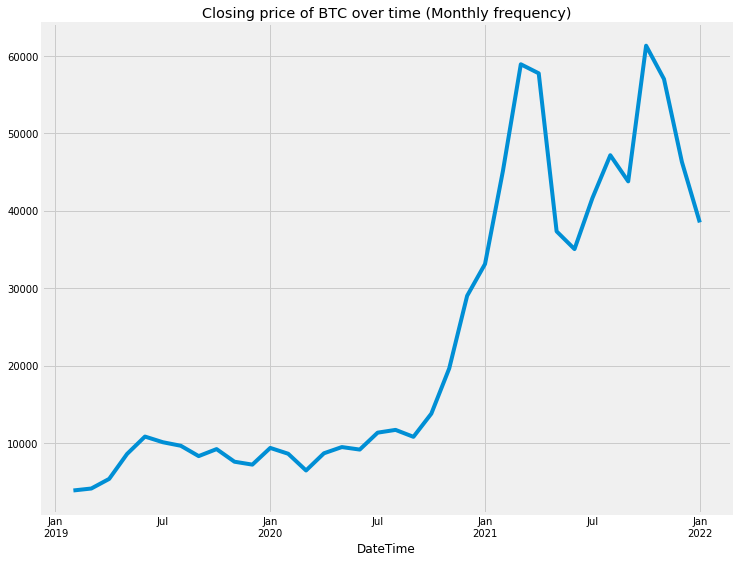

In [15]:
btc["Close"].asfreq('M').interpolate().plot() # asfreq method is used to convert a time series to a specified frequency. 
                                                 # Here it is monthly frequency. Also using interpolate() to fix the gaps between the timeseries
plt.title('Closing price of BTC over time (Monthly frequency)')
plt.show()

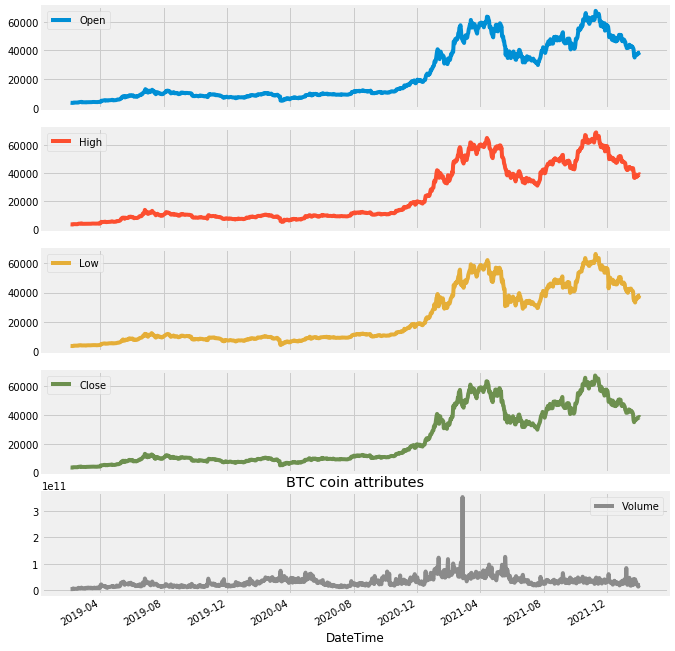

In [16]:
btc[selected_columns].plot(subplots=True, figsize=(10,12))
plt.title('BTC coin attributes')
plt.savefig('BTC.png')
plt.show()

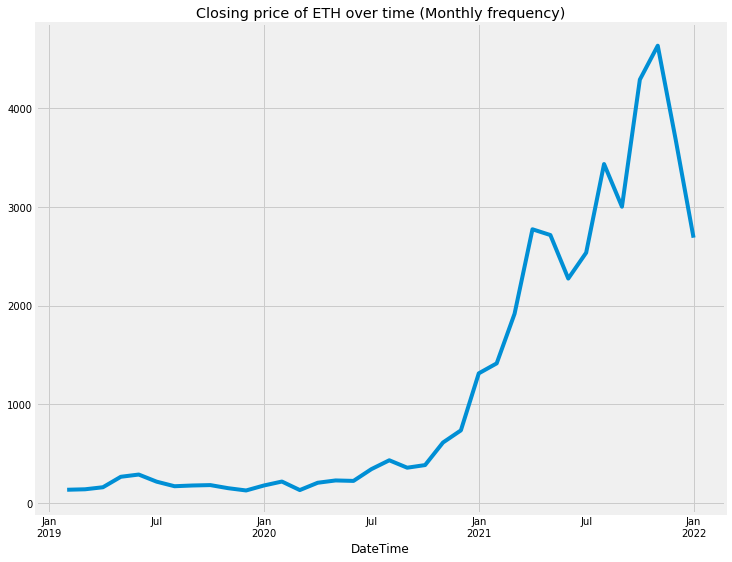

In [17]:
eth["Close"].asfreq('M').interpolate().plot() # asfreq method is used to convert a time series to a specified frequency. 
                                                 # Here it is monthly frequency. Also using interpolate() to fix the gaps between the timeseries
plt.title('Closing price of ETH over time (Monthly frequency)')
plt.show()

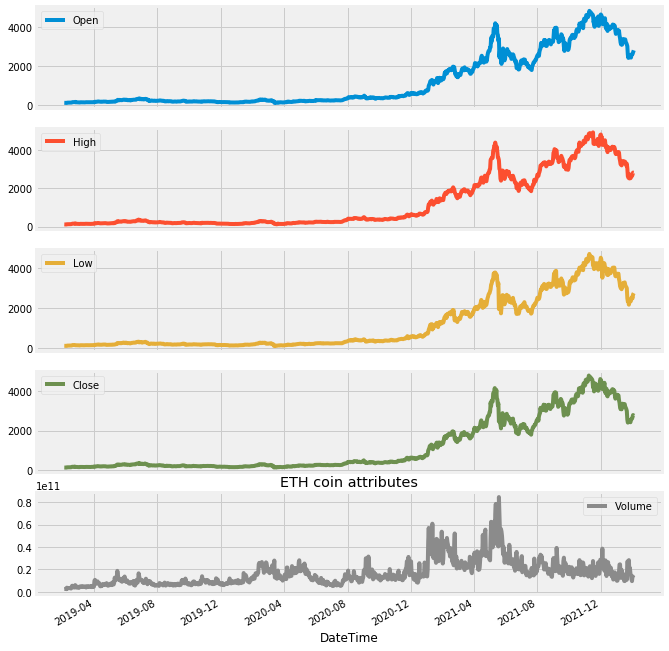

In [18]:
eth[selected_columns].plot(subplots=True, figsize=(10,12))
plt.title('ETH coin attributes')
plt.savefig('ETH.png')
plt.show()

## <a id='1.4'>1.4 Timestamps and Periods</a>

### What are timestamps and periods and how are they useful?
Timestamps are used to represent a point in time. Periods represent an interval in time. Periods can used to check if a specific event in the given period. They can also be converted to each other's form.

In [19]:
# Creating a Timestamp
timestamp = pd.Timestamp(2017, 1, 1, 12)
timestamp

Timestamp('2017-01-01 12:00:00')

In [20]:
# Creating a period
period = pd.Period('2017-01-01')
period

Period('2017-01-01', 'D')

In [21]:
# Checking if the given timestamp exists in the given period
period.start_time < timestamp < period.end_time

True

In [22]:
# Converting timestamp to period
new_period = timestamp.to_period(freq='H')
new_period

Period('2017-01-01 12:00', 'H')

In [23]:
# Converting period to timestamp
new_timestamp = period.to_timestamp(freq='H', how='start')
new_timestamp

Timestamp('2017-01-01 00:00:00')

## <a id='1.5'>1.5 Using date_range</a>

### What is date_range and how is it useful?
**date_range** is a method that returns  a fixed frequency datetimeindex. It is quite useful when creating your own time series attribute for pre-existing data or arranging the whole data around the time series attribute created by you.

In [24]:
# Creating a datetimeindex with daily frequency
dr1 = pd.date_range(start='1/1/18', end='1/9/18')
dr1

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09'],
              dtype='datetime64[ns]', freq='D')

In [25]:
# Creating a datetimeindex with monthly frequency
dr2 = pd.date_range(start='1/1/18', end='1/1/19', freq='M')
dr2

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', freq='M')

In [26]:
# Creating a datetimeindex without specifying start date and using periods
dr3 = pd.date_range(end='1/4/2014', periods=8)
dr3

DatetimeIndex(['2013-12-28', '2013-12-29', '2013-12-30', '2013-12-31',
               '2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04'],
              dtype='datetime64[ns]', freq='D')

In [27]:
# Creating a datetimeindex specifying start date , end date and periods
dr4 = pd.date_range(start='2013-04-24', end='2014-11-27', periods=3)
dr4

DatetimeIndex(['2013-04-24', '2014-02-09', '2014-11-27'], dtype='datetime64[ns]', freq=None)

## <a id='1.6'>1.6 Using to_datetime</a> 

pandas.to_datetime() is used for converting arguments to datetime. Here, a DataFrame is converted to a datetime series.

In [28]:
df = pd.DataFrame({'year': [2015, 2016], 'month': [2, 3], 'day': [4, 5]})
df

year  month  day
0  2015      2    4
1  2016      3    5

In [29]:
df = pd.to_datetime(df)
df

0   2015-02-04
1   2016-03-05
dtype: datetime64[ns]

In [30]:
df = pd.to_datetime('01-01-2017')
df

Timestamp('2017-01-01 00:00:00')

## <a id='1.7'>1.7 Shifting and lags</a>

We can shift index by desired number of periods with an optional time frequency. This is useful when comparing the time series with a past of itself

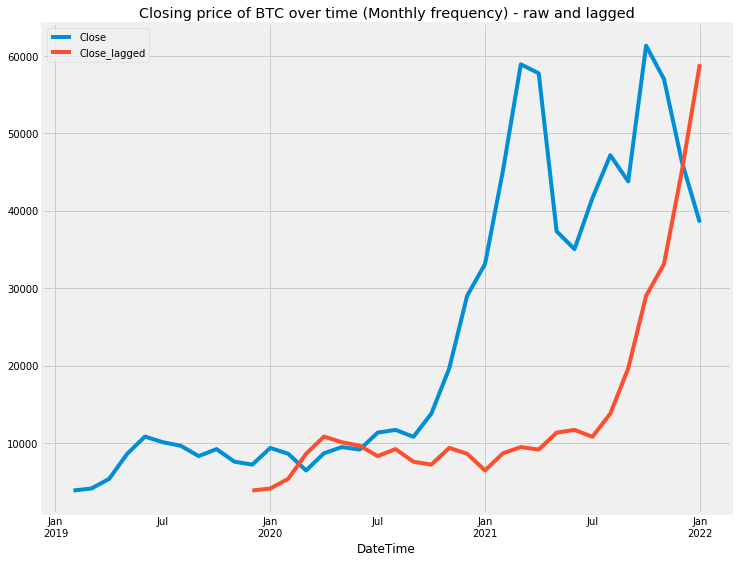

In [31]:
btc["Close"].asfreq('M').interpolate().plot(legend=True)
shifted = btc["Close"].asfreq('M').interpolate().shift(10).plot(legend=True)
shifted.legend(['Close','Close_lagged'])
plt.title('Closing price of BTC over time (Monthly frequency) - raw and lagged')
plt.show()

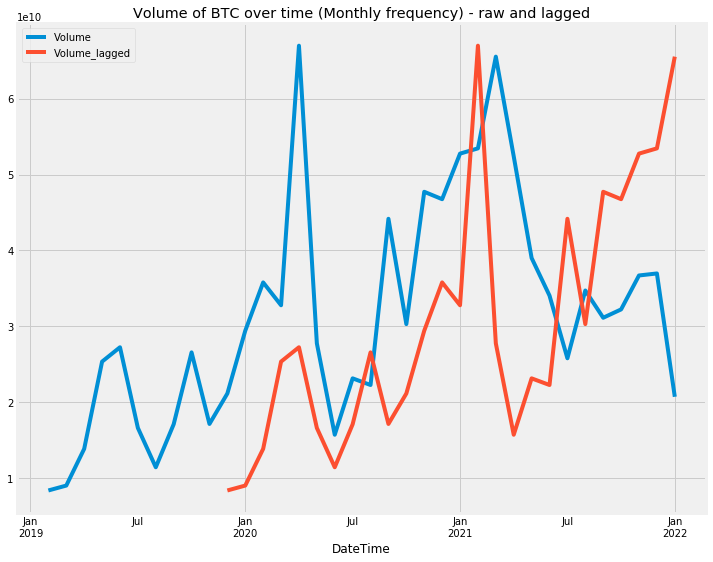

In [32]:
btc["Volume"].asfreq('M').interpolate().plot(legend=True)
shifted = btc["Volume"].asfreq('M').interpolate().shift(10).plot(legend=True)
shifted.legend(['Volume','Volume_lagged'])
plt.title('Volume of BTC over time (Monthly frequency) - raw and lagged')
plt.show()

## <a id='#1.8'>1.8 Resampling</a>
**Upsampling** - Time series is resampled from low frequency to high frequency (Monthly to daily frequency). It involves filling or interpolating missing data

**Downsampling** - Time series is resampled from high frequency to low frequency (Weekly to monthly frequency). It involves aggregation of existing data.


In case there were missing data, we would use **ffill** parameter which propagates last valid observation to fill gaps. Then we would use **bfill** to propogate next valid observation to fill gaps.

_Forward filling missing data_

```python
data = data.iloc[1:]
data = data.fillna(method='ffill')
```

_Back filling missing data_

```python
data = data.fillna(method='bfill')
data.head()
```

In [33]:
# Shape before resampling(downsampling)
btc.shape

(1096, 5)

In [34]:
# We downsample from hourly to 3 day frequency aggregated using mean
btc_resampled = btc.resample('3D').mean()
btc_resampled.head()

Open         High      ...             Close        Volume
DateTime                                  ...                                
2019-02-03  3479.434082  3491.920085      ...       3463.174967  5.201402e+09
2019-02-06  3428.465902  3530.883789      ...       3493.339925  6.074261e+09
2019-02-09  3680.133464  3690.196859      ...       3669.940837  6.239382e+09
2019-02-12  3642.508708  3661.530029      ...       3634.159993  6.396778e+09
2019-02-15  3621.999349  3660.391276      ...       3641.478190  6.355403e+09

[5 rows x 5 columns]

In [35]:
# Shape after resampling(downsampling)
btc_resampled.shape

(366, 5)

Much less rows are left. Now, we will upsample from 3 day frequency to daily frequency

In [36]:
btc_resampled = btc.resample('D').pad()
btc_resampled.head()

Open         High     ...            Close      Volume
DateTime                                 ...                             
2019-02-03  3516.139648  3521.388184     ...      3464.013428  5043937584
2019-02-04  3467.211670  3476.223877     ...      3459.154053  5332718886
2019-02-05  3454.950928  3478.148193     ...      3466.357422  5227549545
2019-02-06  3469.091797  3469.091797     ...      3413.767822  5482196038
2019-02-07  3414.929443  3427.945557     ...      3399.471680  5004962683

[5 rows x 5 columns]

In [37]:
# Shape after resampling(upsampling)
btc_resampled.shape

(1096, 5)

Again an increase in number of rows. Resampling is cool when used properly.

# <a id='2'>2. Finance and statistics</a>

## <a id='2.1'>2.1 Percent change</a>

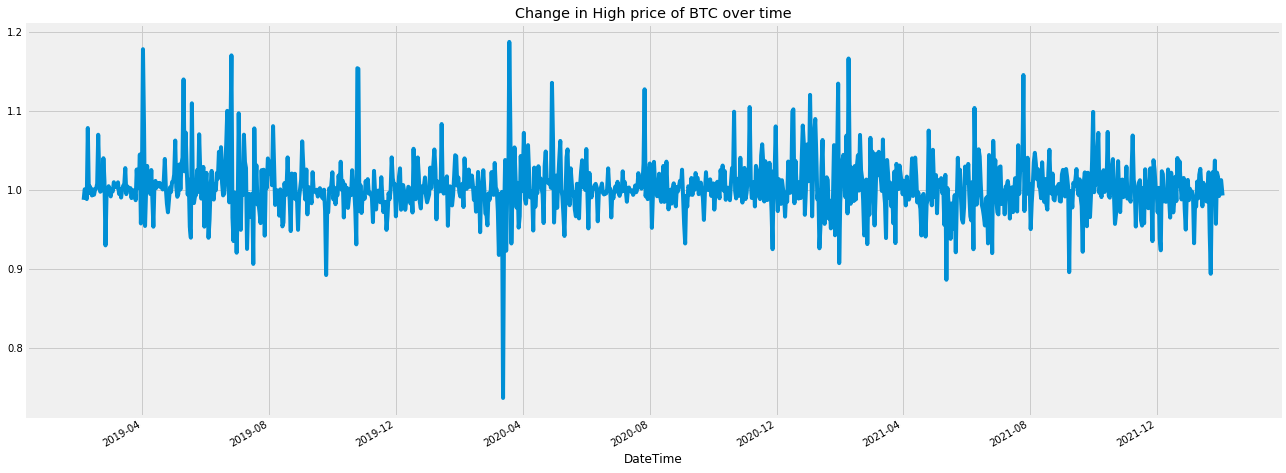

In [38]:
btc['Change'] = btc.High.div(btc.High.shift())
btc['Change'].plot(figsize=(20,8))
_ = plt.title('Change in High price of BTC over time')

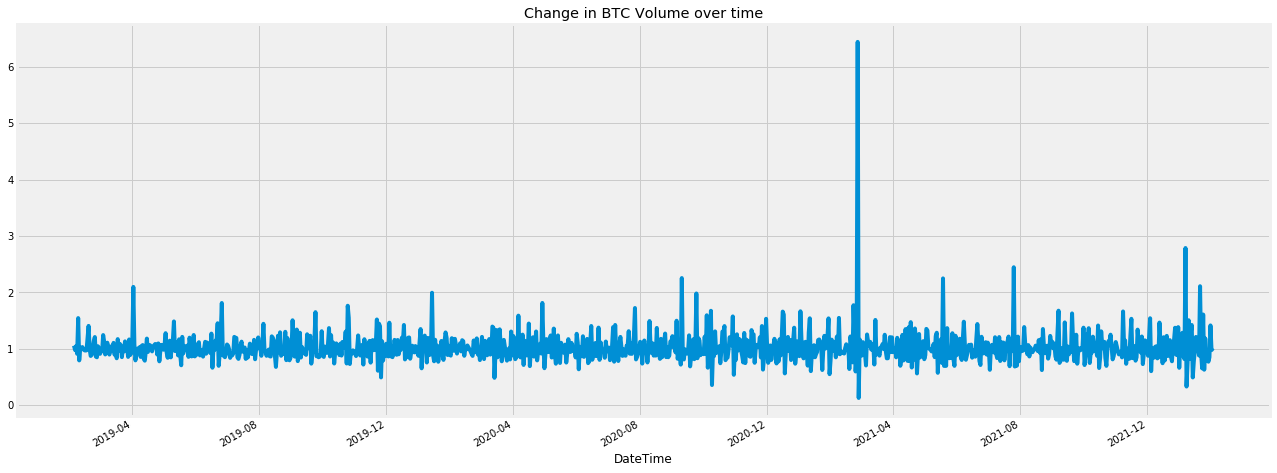

In [39]:
btc['Volume_Change'] = btc.Volume.div(btc.Volume.shift())
btc['Volume_Change'].plot(figsize=(20,8))
_ = plt.title('Change in BTC Volume over time')

## <a id='2.2'>2.2 Daily returns</a> 

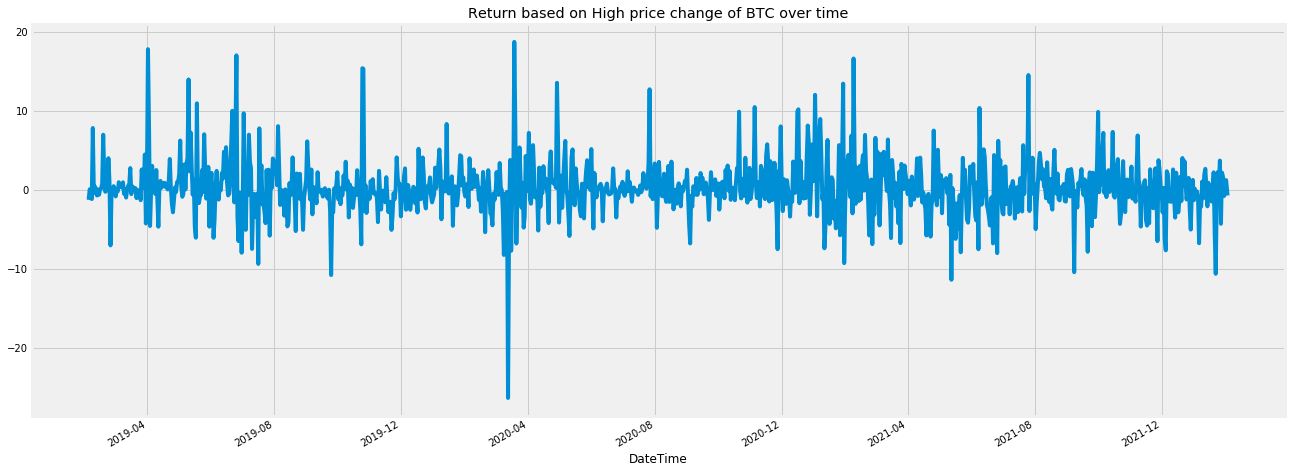

In [40]:
btc['Return'] = btc.Change.sub(1).mul(100)
btc['Return'].plot(figsize=(20,8))
_ = plt.title('Return based on High price change of BTC over time')

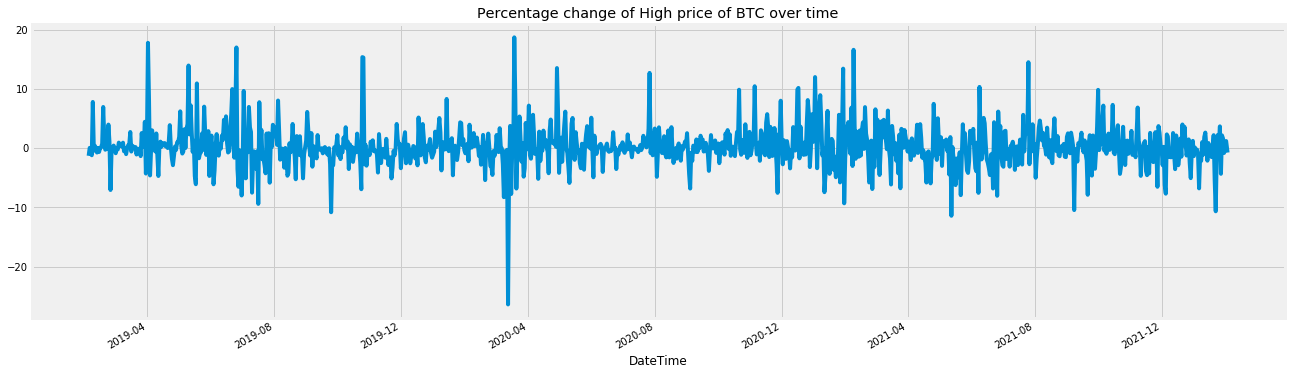

In [41]:
btc.High.pct_change().mul(100).plot(figsize=(20,6)) # Another way to calculate returns
_ = plt.title('Percentage change of High price of BTC over time')

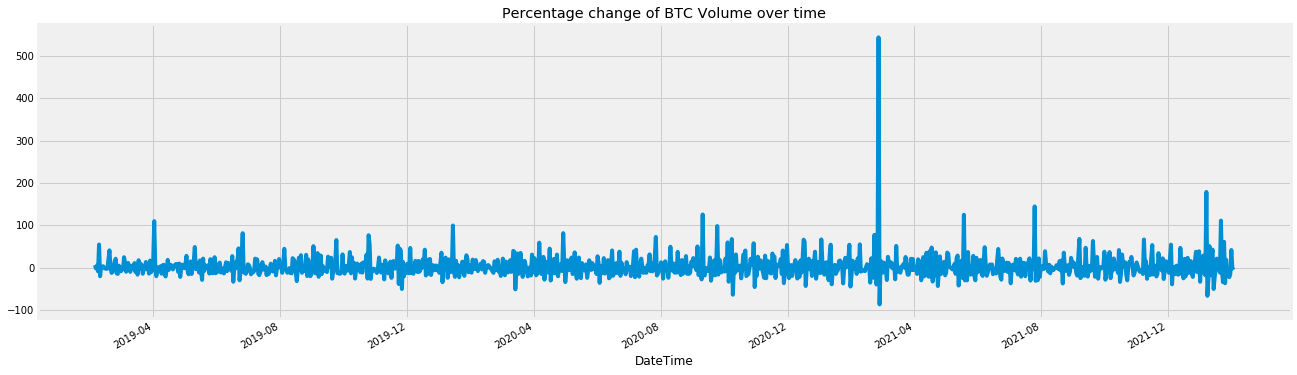

In [42]:
btc.Volume.pct_change().mul(100).plot(figsize=(20,6)) # Another way to calculate returns
_ = plt.title('Percentage change of BTC Volume over time')

## <a id='2.3'>2.3 Absolute change in successive rows</a>

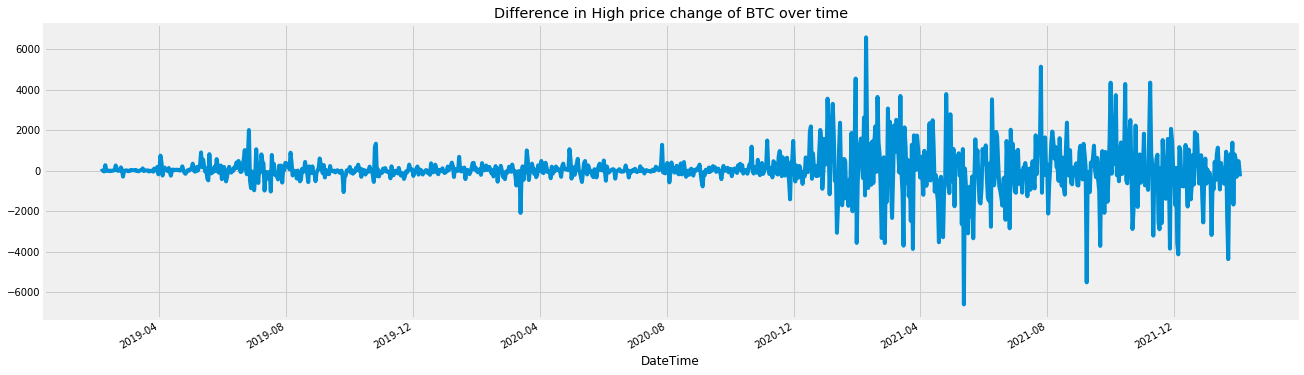

In [43]:
btc.High.diff().plot(figsize=(20,6))
_ = plt.title('Difference in High price change of BTC over time')

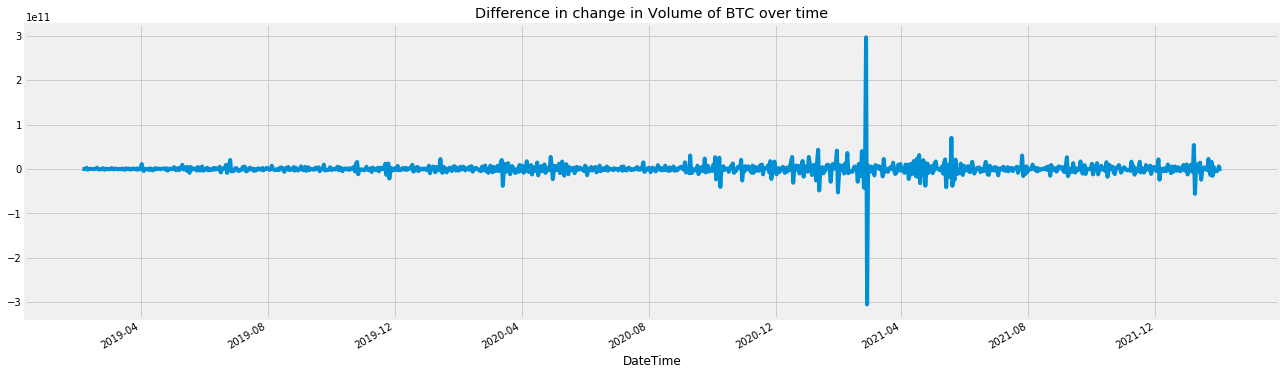

In [44]:
btc.Volume.diff().plot(figsize=(20,6))
_ = plt.title('Difference in change in Volume of BTC over time')

## <a id='2.4'>2.4 Comparing two or more time series</a> 

We will compare 2 time series by normalizing them. This is achieved by dividing each time series element of all time series by the first element. This way both series start at the same point and can be easily compared.

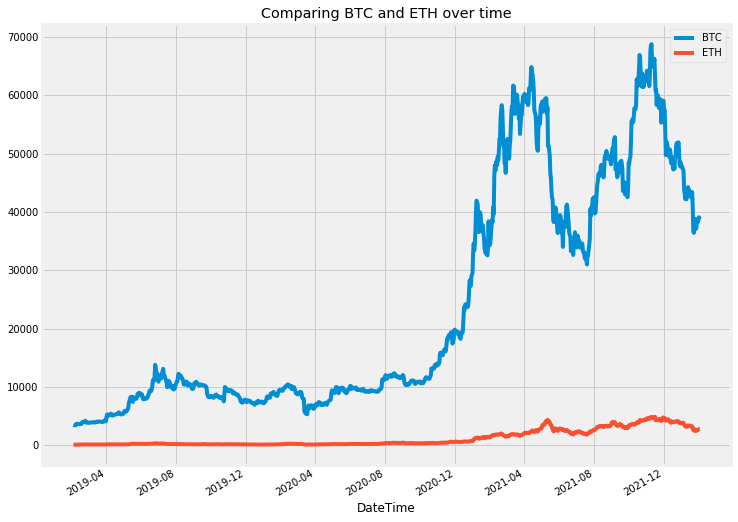

In [45]:
# Plotting before normalization
btc.High.plot()
eth.High.plot()
plt.legend(['BTC','ETH'])
_ = plt.title('Comparing BTC and ETH over time')
plt.show()

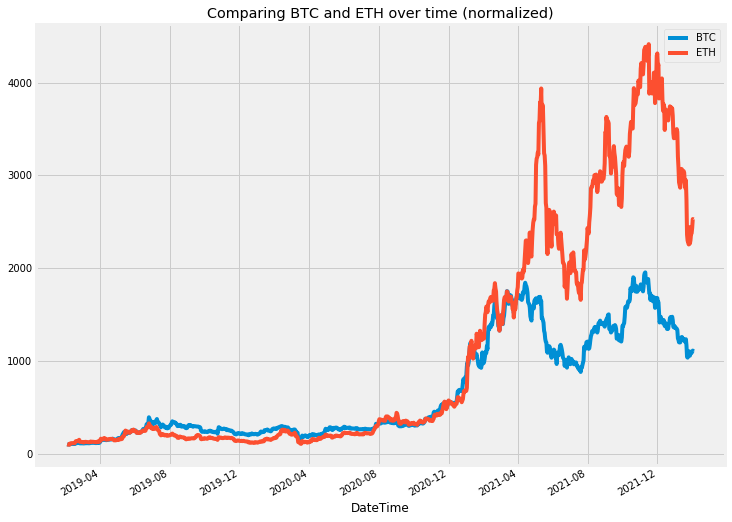

In [46]:
# Normalizing and comparison
# Both coins start from 100
normalized_btc = btc.High.div(btc.High.iloc[0]).mul(100)
normalized_eth = eth.High.div(eth.High.iloc[0]).mul(100)
normalized_btc.plot()
normalized_eth.plot()
_ = plt.title('Comparing BTC and ETH over time (normalized)')
plt.legend(['BTC','ETH'])
plt.show()

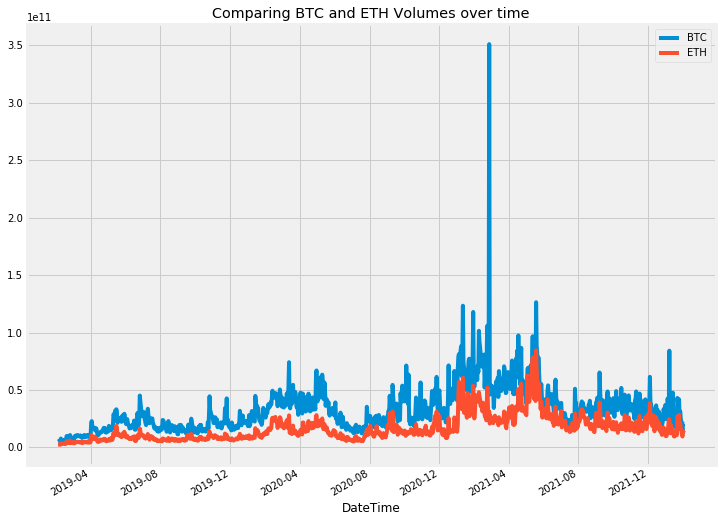

In [47]:
# Plotting before normalization
btc.Volume.plot()
eth.Volume.plot()
plt.legend(['BTC','ETH'])
_ = plt.title('Comparing BTC and ETH Volumes over time')
plt.show()

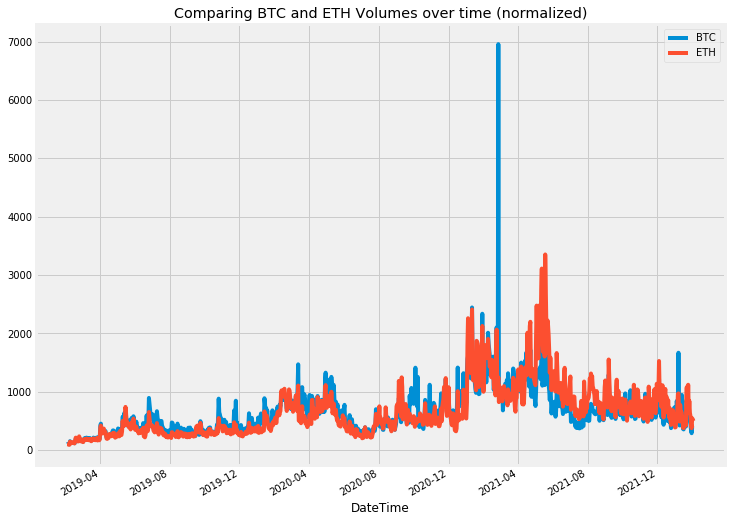

In [48]:
# Normalizing and comparison
# Both coin start from 100
normalized_btc = btc.Volume.div(btc.Volume.iloc[0]).mul(100)
normalized_eth = eth.Volume.div(eth.Volume.iloc[0]).mul(100)
normalized_btc.plot()
normalized_eth.plot()
_ = plt.title('Comparing BTC and ETH Volumes over time (normalized)')
plt.legend(['BTC','ETH'])
plt.show()

You can clearly see how BTC outperforms ETH over time.

## <a id='2.5'>2.5 Window functions</a>
Window functions are used to identify sub periods, calculates sub-metrics of sub-periods.

**Rolling** - Same size and sliding

**Expanding** - Contains all prior values

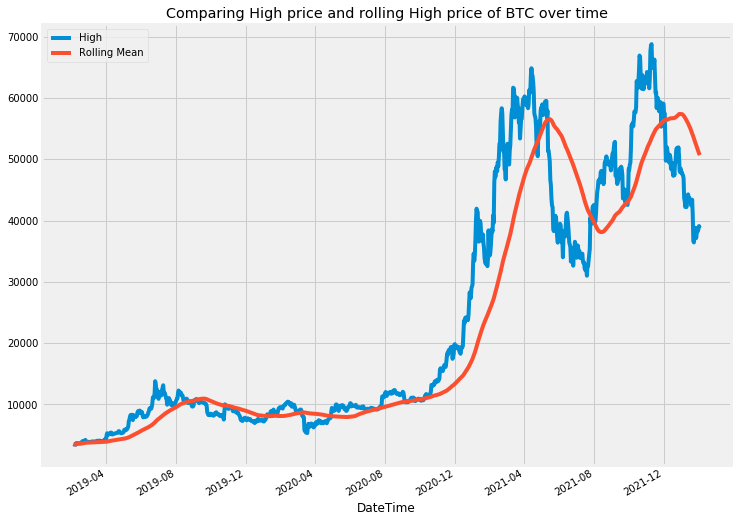

In [49]:
# Rolling window functions
rolling_btc = btc.High.rolling('90D').mean()
btc.High.plot()
rolling_btc.plot()
_ = plt.title('Comparing High price and rolling High price of BTC over time')
plt.legend(['High','Rolling Mean'])
# Plotting a rolling mean of 90 day window with original High attribute of BTC
plt.show()

Now, observe that rolling mean plot is a smoother version of the original plot.

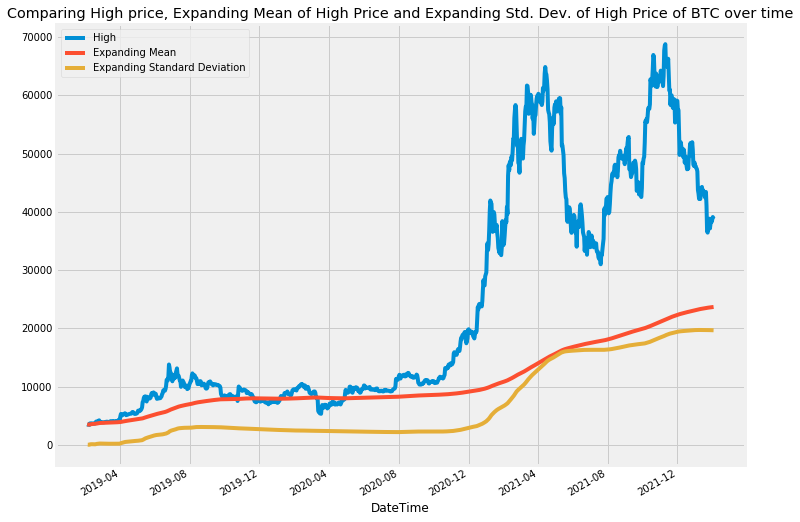

In [50]:
# Expanding window functions
btc_mean = btc.High.expanding().mean()
btc_std = btc.High.expanding().std()
btc.High.plot()
btc_mean.plot()
btc_std.plot()
_ = plt.title('Comparing High price, Expanding Mean of High Price and Expanding Std. Dev. of High Price of BTC over time')
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])
plt.show()

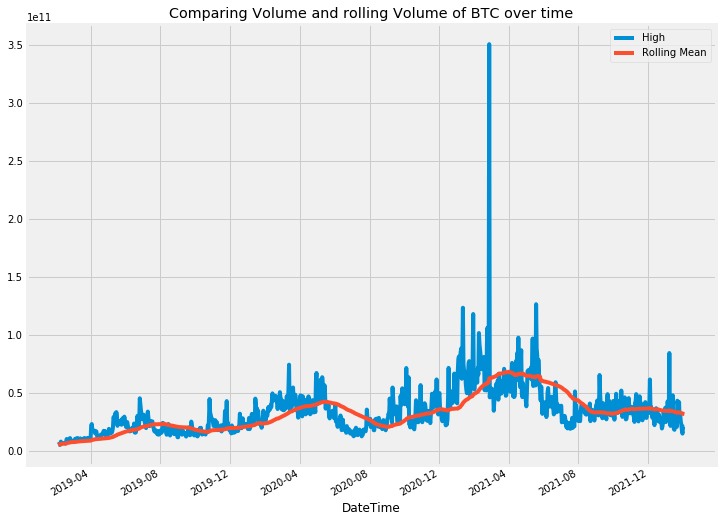

In [51]:
# Rolling window functions
rolling_btc = btc.Volume.rolling('90D').mean()
btc.Volume.plot()
rolling_btc.plot()
_ = plt.title('Comparing Volume and rolling Volume of BTC over time')
plt.legend(['High','Rolling Mean'])
# Plotting a rolling mean of 90 day window with original High attribute of BTC
plt.show()

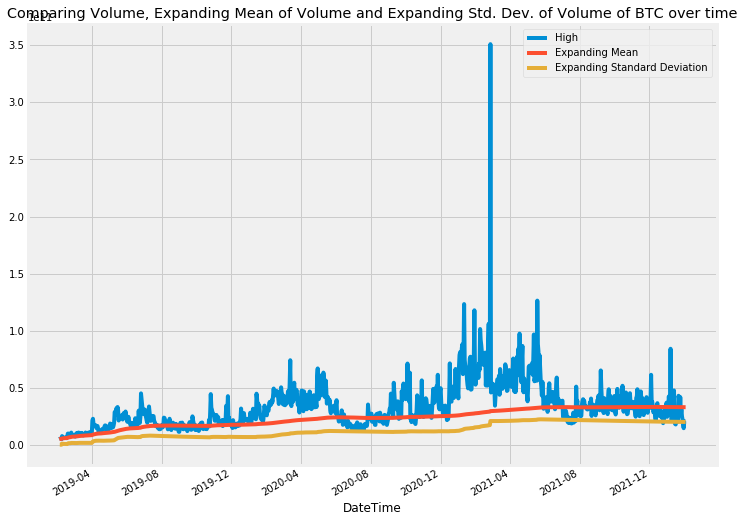

In [52]:
# Expanding window functions
btc_mean = btc.Volume.expanding().mean()
btc_std = btc.Volume.expanding().std()
btc.Volume.plot()
btc_mean.plot()
btc_std.plot()
_ = plt.title('Comparing Volume, Expanding Mean of Volume and Expanding Std. Dev. of Volume of BTC over time')
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])
plt.show()

## <a id='2.6'>2.6 OHLC charts</a>
An OHLC chart is any type of price chart that shows the open, high, low and close price of a certain time period. Open-high-low-close Charts (or OHLC Charts) are used as a trading tool to visualise and analyse the price changes over time for securities, currencies, stocks, bonds, commodities, etc. OHLC Charts are useful for interpreting the day-to-day sentiment of the market and forecasting any future price changes through the patterns produced.

The y-axis on an OHLC Chart is used for the price scale, while the x-axis is the timescale. On each single time period, an OHLC Charts plots a symbol that represents two ranges: the highest and lowest prices traded, and also the opening and closing price on that single time period (for example in a day). On the range symbol, the high and low price ranges are represented by the length of the main vertical line. The open and close prices are represented by the vertical positioning of tick-marks that appear on the left (representing the open price) and on right (representing the close price) sides of the high-low vertical line.

Colour can be assigned to each OHLC Chart symbol, to distinguish whether the market is "bullish" (the closing price is higher then it opened) or "bearish" (the closing price is lower then it opened).

<img src="https://datavizcatalogue.com/methods/images/anatomy/SVG/OHLC_chart.svg">

Source: [Datavizcatalogue](https://datavizcatalogue.com/methods/OHLC_chart.html)

In [53]:
# OHLC chart of June 2008
trace = go.Ohlc(x=btc['06-2021'].index,
                open=btc['06-2021'].Open,
                high=btc['06-2021'].High,
                low=btc['06-2021'].Low,
                close=btc['06-2021'].Close)
data = [trace]
print('OHLC price chart of BTC for June 2021')
iplot(data, filename='simple_ohlc')

OHLC price chart of BTC for June 2021


 ## <a id='2.7'>2.7 Candlestick charts</a>
This type of chart is used as a trading tool to visualise and analyse the price movements over time for securities, derivatives, currencies, stocks, bonds, commodities, etc. Although the symbols used in Candlestick Charts resemble a Box Plot, they function differently and therefore, are not to be confused with one another.

Candlestick Charts display multiple bits of price information such as the open price, close price, highest price and lowest price through the use of candlestick-like symbols. Each symbol represents the compressed trading activity for a single time period (a minute, hour, day, month, etc). Each Candlestick symbol is plotted along a time scale on the x-axis, to show the trading activity over time.

The main rectangle in the symbol is known as the real body, which is used to display the range between the open and close price of that time period. While the lines extending from the bottom and top of the real body is known as the lower and upper shadows (or wick). Each shadow represents the highest or lowest price traded during the time period represented. When the market is Bullish (the closing price is higher than it opened), then the body is coloured typically white or green. But when the market is Bearish (the closing price is lower than it opened), then the body is usually coloured either black or red.

<img src="https://datavizcatalogue.com/methods/images/anatomy/SVG/candlestick_chart.svg">

Candlestick Charts are great for detecting and predicting market trends over time and are useful for interpreting the day-to-day sentiment of the market, through each candlestick symbol's colouring and shape. For example, the longer the body is, the more intense the selling or buying pressure is. While, a very short body, would indicate that there is very little price movement in that time period and represents consolidation.

Candlestick Charts help reveal the market psychology (the fear and greed experienced by sellers and buyers) through the various indicators, such as shape and colour, but also by the many identifiable patterns that can be found in Candlestick Charts. In total, there are 42 recognised patterns that are divided into simple and complex patterns. These patterns found in Candlestick Charts are useful for displaying price relationships and can be used for predicting the possible future movement of the market. You can find a list and description of each pattern here.

Please bear in mind, that Candlestick Charts don't express the events taking place between the open and close price - only the relationship between the two prices. So you can't tell how volatile trading was within that single time period.

Source: [Datavizcatalogue](https://datavizcatalogue.com/methods/candlestick_chart.html)

In [54]:
# Candlestick chart of march 2008
trace = go.Candlestick(x=btc['06-2021'].index,
                open=btc['06-2021'].Open,
                high=btc['06-2021'].High,
                low=btc['06-2021'].Low,
                close=btc['06-2021'].Close)
data = [trace]
print('OHLC price chart (Candlestick) of BTC for June 2021')
iplot(data, filename='simple_candlestick')

OHLC price chart (Candlestick) of BTC for June 2021


## <a id='2.8'>2.8 Autocorrelation and Partial Autocorrelation</a>
* Autocorrelation - The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.
* Partial Autocorrelation - The partial autocorrelation function can be interpreted as a regression of the series against its past lags.  The terms can be interpreted the same way as a standard  linear regression, that is the contribution of a change in that particular lag while holding others constant. 

Source: [Quora](https://www.quora.com/What-is-the-difference-among-auto-correlation-partial-auto-correlation-and-inverse-auto-correlation-while-modelling-an-ARIMA-series)

## Autocorrelation

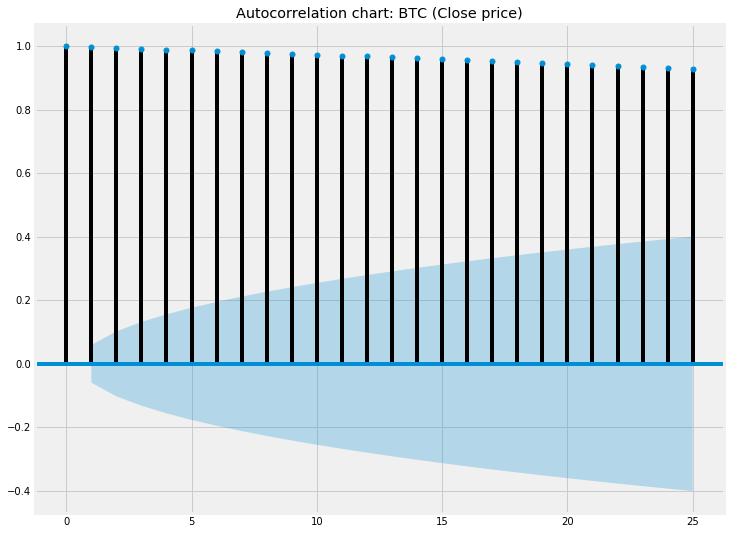

In [55]:
# Autocorrelation of Closing price of BTC
plot_acf(btc["Close"],lags=25,title="Autocorrelation chart: BTC (Close price)")
plt.show()

 As all lags are either close to 1 or at least greater than the confidence interval, they are statistically significant.

## Partial Autocorrelation

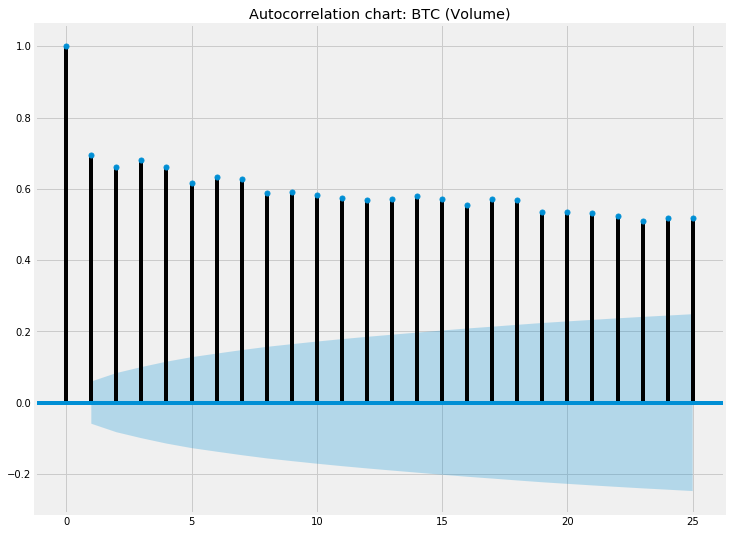

In [56]:
# Autocorrelation of Volume of BTC
plot_acf(btc["Volume"],lags=25,title="Autocorrelation chart: BTC (Volume)")
plt.show()

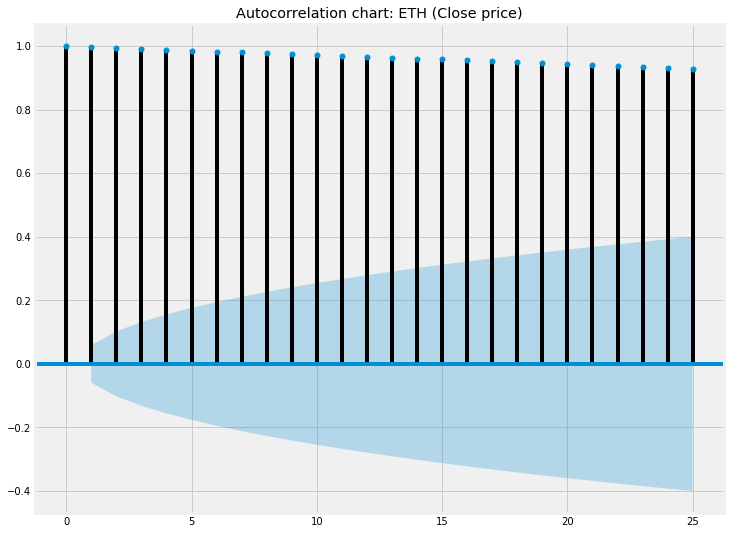

In [57]:
# Autocorrelation of Closing price of Ethereum
plot_acf(eth["Close"],lags=25,title="Autocorrelation chart: ETH (Close price)")
plt.show()

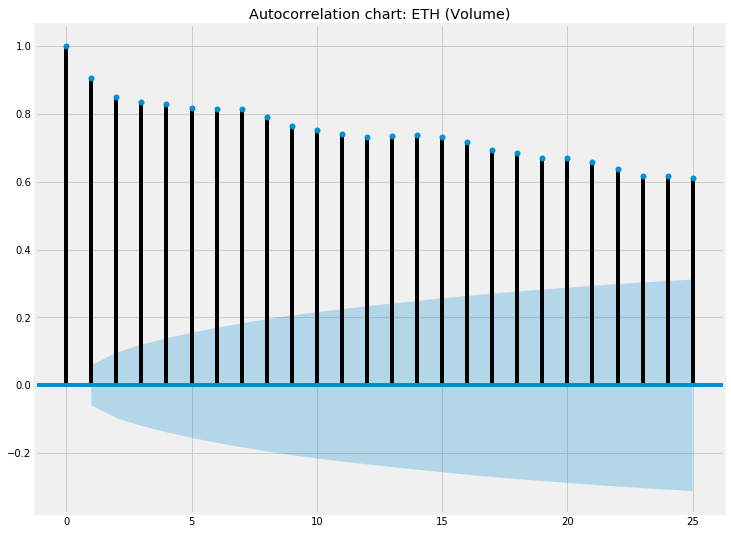

In [58]:
# Autocorrelation of Volume of ETH
plot_acf(eth["Volume"],lags=25,title="Autocorrelation chart: ETH (Volume)")
plt.show()

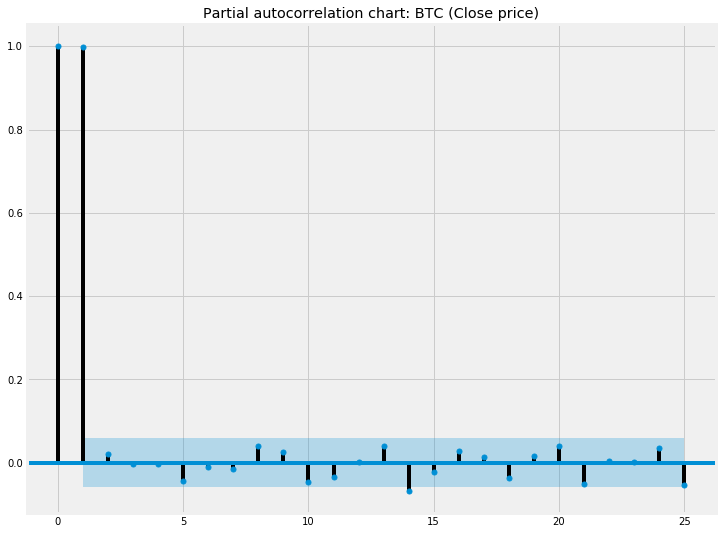

In [59]:
# Partial Autocorrelation of Closing price of BTC
plot_pacf(btc["Close"],lags=25, title="Partial autocorrelation chart: BTC (Close price)")
plt.show()

Though it is statistically signficant, partial autocorrelation after first 2 lags is very low.

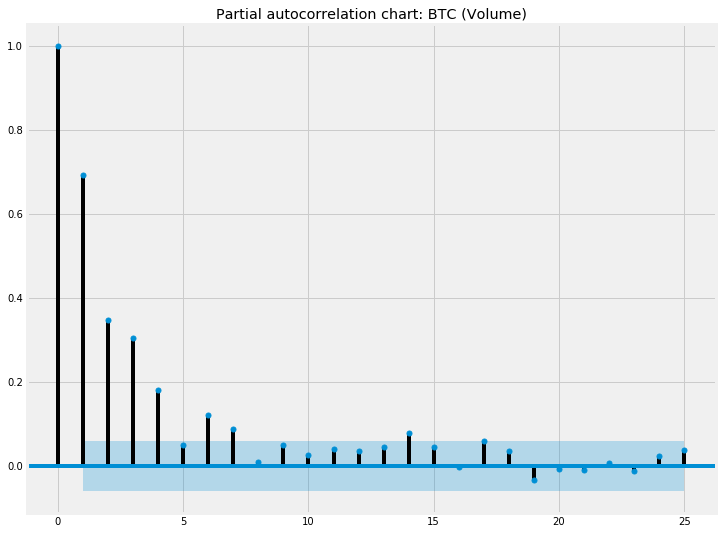

In [60]:
# Partial Autocorrelation of Volume of BTC
plot_pacf(btc["Volume"],lags=25, title="Partial autocorrelation chart: BTC (Volume)")
plt.show()

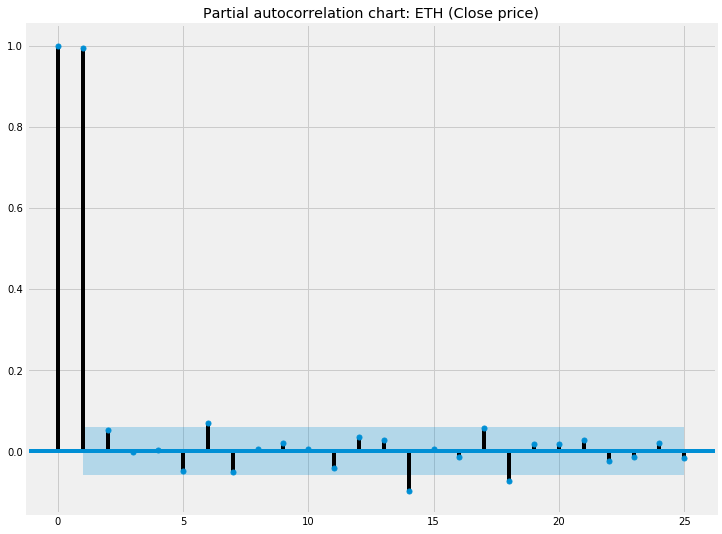

In [61]:
# Partial Autocorrelation of closing price of ETH 
plot_pacf(eth["Close"],lags=25, title="Partial autocorrelation chart: ETH (Close price)")
plt.show()

Here, only 0th and 1st lag are statistically significant.

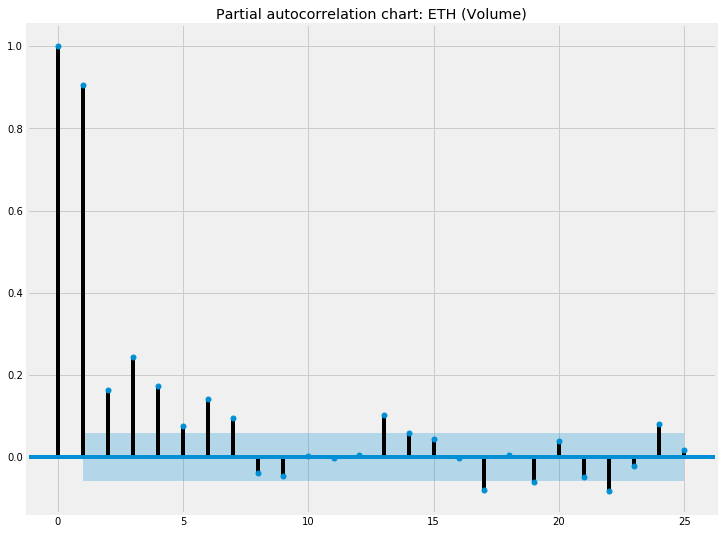

In [62]:
# Partial Autocorrelation of Volume of ETH
plot_pacf(eth["Volume"],lags=25, title="Partial autocorrelation chart: ETH (Volume)")
plt.show()

# <a id='3'>3. Time series decomposition and Random walks</a>

## <a id='3.1'>3.1. Trends, seasonality and noise</a>
These are the components of a time series
* Trend - Consistent upwards or downwards slope of a time series
* Seasonality - Clear periodic pattern of a time series(like sine funtion)
* Noise - Outliers or missing values

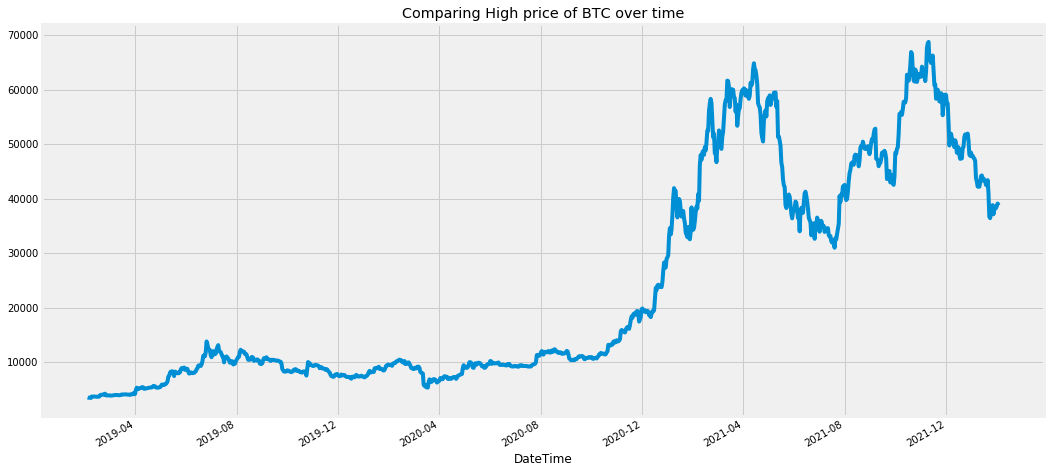

In [63]:
# Let's take BTC's High for this
btc["High"].plot(figsize=(16,8))
_ = plt.title('Comparing High price of BTC over time')

Decomposing closing price of BTC over time


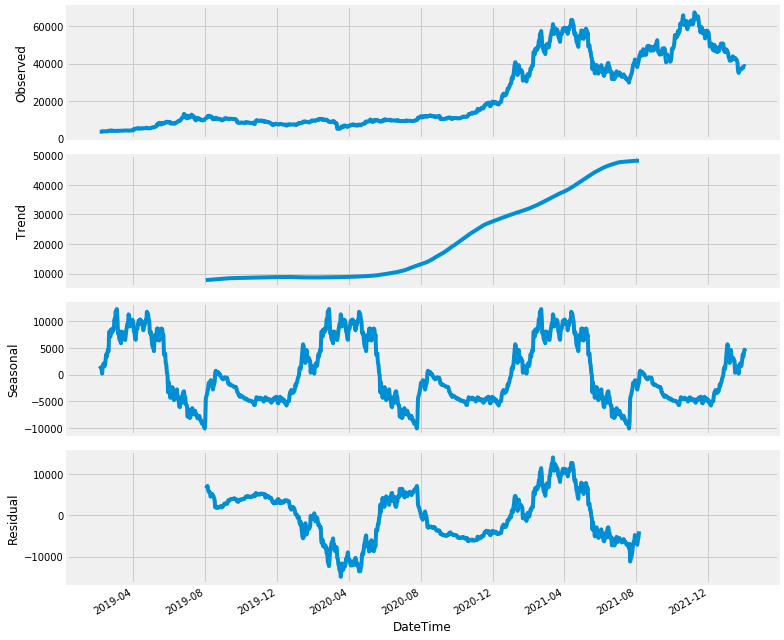

In [64]:
# Now, for decomposition...
print('Decomposing closing price of BTC over time')
decomposed_btc_close = sm.tsa.seasonal_decompose(btc["Close"],freq=360) # The frequncy is annual
figure = decomposed_btc_close.plot()
plt.show()

Decomposing volume data of BTC over time


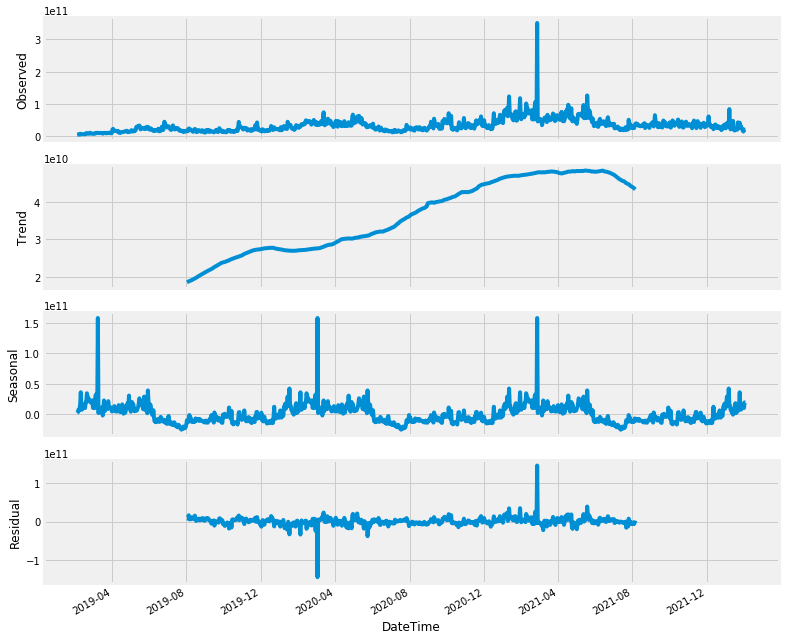

In [65]:
# Now, for decomposition...
print('Decomposing volume data of BTC over time')
decomposed_btc_volume = sm.tsa.seasonal_decompose(btc["Volume"],freq=360) # The frequncy is annual
figure = decomposed_btc_volume.plot()
plt.show()

* There is clearly an upward trend in the above plots.
* You can also see the uniform seasonal change.
* Non-uniform noise that represent outliers and/or missing values

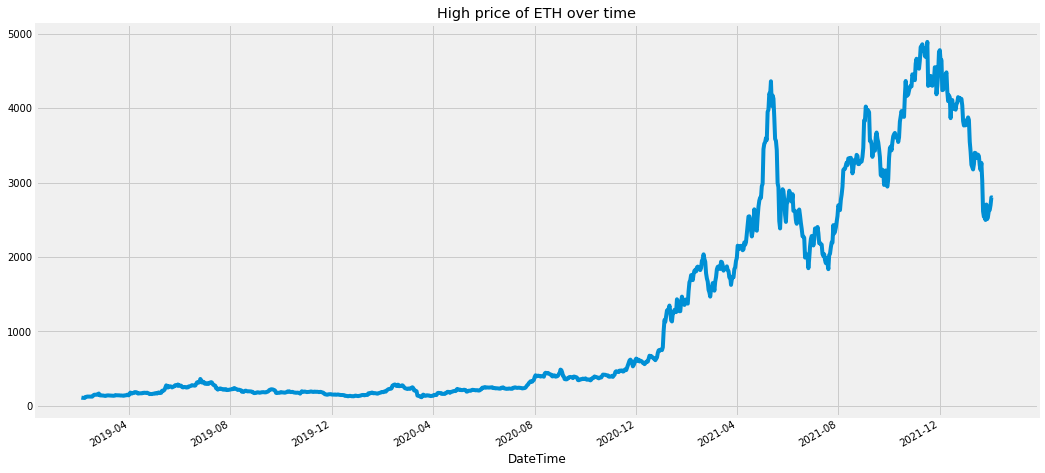

In [66]:
# Let's take ETH's High for this
eth["High"].plot(figsize=(16,8))
_ = plt.title('High price of ETH over time')

Decomposing closing price of ETH over time


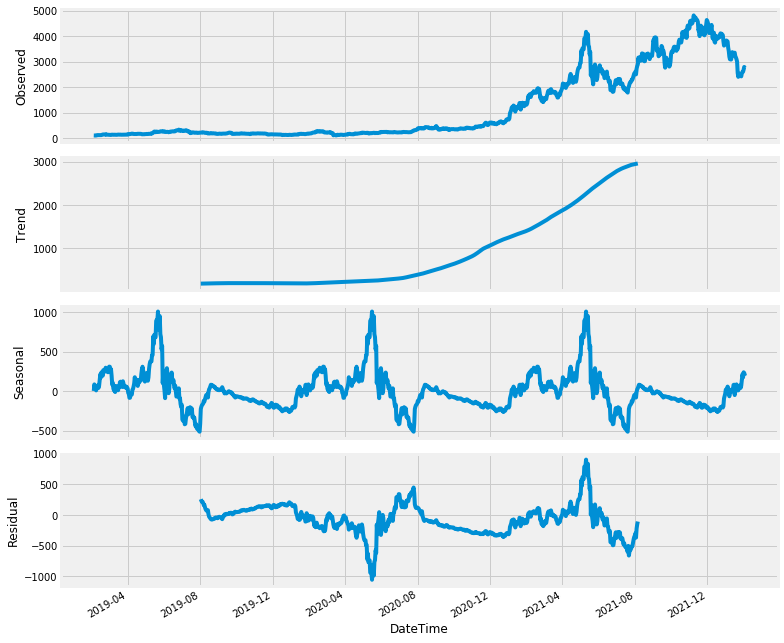

In [67]:
# Now, for decomposition...
print('Decomposing closing price of ETH over time')
decomposed_eth_close = sm.tsa.seasonal_decompose(eth["Close"],freq=360) # The frequncy is annual
figure = decomposed_eth_close.plot()
plt.show()

Decomposing volume data of ETH over time


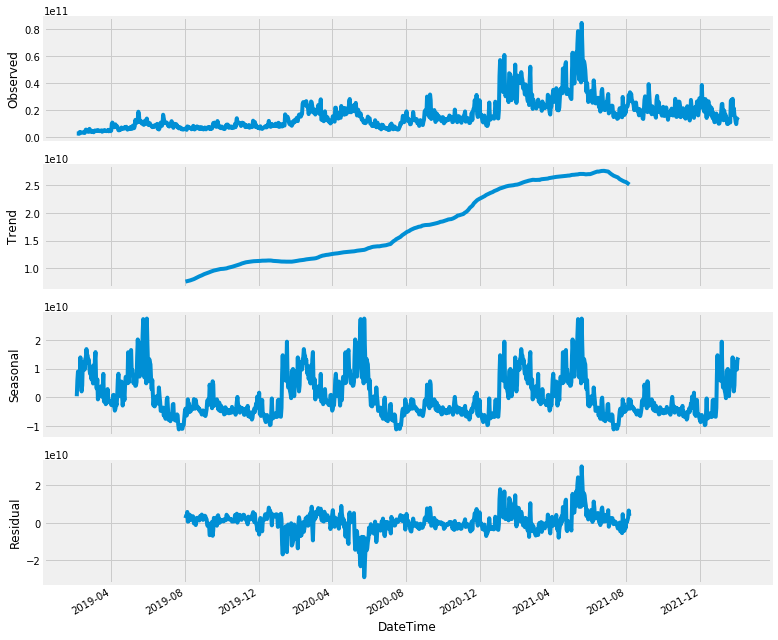

In [68]:
# Now, for decomposition...
print('Decomposing volume data of ETH over time')
decomposed_eth_volume = sm.tsa.seasonal_decompose(eth["Volume"],freq=360) # The frequncy is annual
figure = decomposed_eth_volume.plot()
plt.show()

## <a id='3.2'>3.2. White noise</a>
White noise has...
* Constant mean
* Constant variance
* Zero auto-correlation at all lags

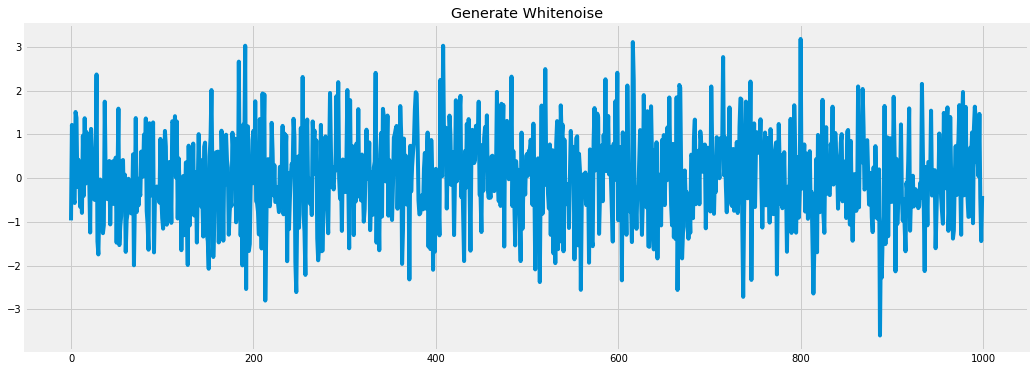

In [69]:
# Plotting white noise
rcParams['figure.figsize'] = 16, 6
white_noise = np.random.normal(loc=0, scale=1, size=1000)
_ = plt.title('Generate Whitenoise')
# loc is mean, scale is variance
plt.plot(white_noise)

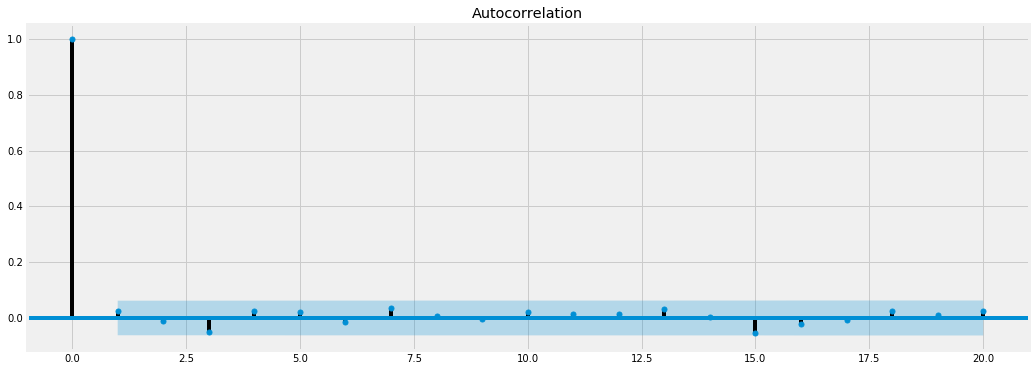

In [70]:
# Plotting autocorrelation of white noise
plot_acf(white_noise,lags=20)
plt.show()

See how all lags are statistically insigficant as they lie inside the confidence interval(shaded portion).

## <a id='3.3'>3.3. Random Walk</a>
A random walk is a mathematical object, known as a stochastic or random process, that describes a path that consists of a succession of random steps on some mathematical space such as the integers. 

In general if we talk about stocks, Today's Price = Yesterday's Price + Noise

# P<sub>t</sub> = P<sub>t-1</sub> + ε<sub>t</sub> 

Random walks can't be forecasted because well, noise is random.

Random Walk with Drift(drift(μ) is zero-mean)
#### P<sub>t</sub> - P<sub>t-1</sub> = μ + ε<sub>t</sub> 
<br>
Regression test for random walk 
#### P<sub>t</sub> = α + βP<sub>t-1</sub> + ε<sub>t</sub>
#### Equivalent to  P<sub>t</sub> - P<sub>t-1</sub> = α + βP<sub>t-1</sub> + ε<sub>t</sub>
<br>
Test:
#### H<sub>0</sub>: β = 1 (This is a random walk)
#### H<sub>1</sub>: β < 1 (This is not a random walk)
<br>
Dickey-Fuller Test:
#### H<sub>0</sub>: β = 0 (This is a random walk)
#### H<sub>1</sub>: β < 0 (This is not a random walk)

### Augmented Dickey-Fuller test
An augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. It is basically Dickey-Fuller test with more lagged changes on RHS.

In [71]:
%%time
# Augmented Dickey-Fuller test on volume of BTC and ETH coins 
adf = adfuller(btc["Volume"])
print("p-value of BTC: {}".format(float(adf[1])))
adf = adfuller(eth["Volume"])
print("p-value of ETH: {}".format(float(adf[1])))

p-value of BTC: 0.09747523716272533
p-value of ETH: 0.03759208501380178
CPU times: user 231 ms, sys: 187 ms, total: 418 ms
Wall time: 116 ms


##### As BTC has p-value 0.000033662 which is less than 0.05, null hypothesis is rejected and this is not a random walk.
##### Now ETH has p-value 0.000033662 which is also less than 0.05, null hypothesis is rejected and this is not a random walk.

### Generating a random walk

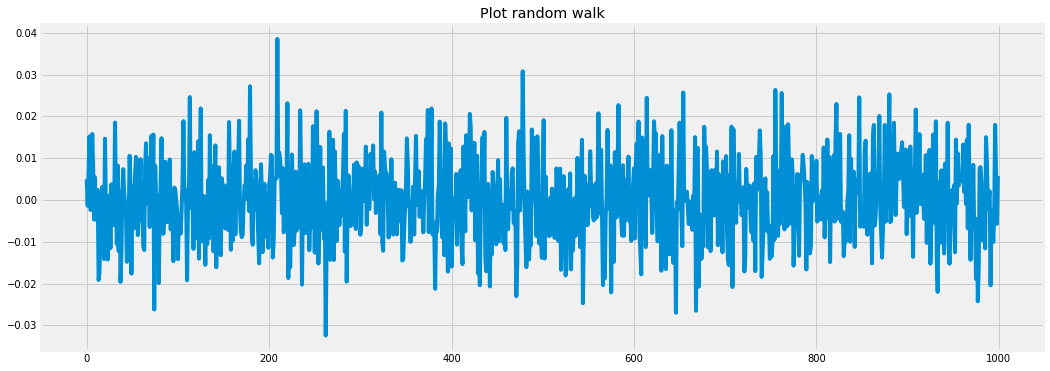

In [72]:
seed(42)
rcParams['figure.figsize'] = 16, 6
random_walk = normal(loc=0, scale=0.01, size=1000)
_ = plt.title('Plot random walk')
plt.plot(random_walk)
plt.show()

In [73]:
fig = ff.create_distplot([random_walk],['Random Walk'],bin_size=0.001)
print('Random walk data distribution')
iplot(fig, filename='Basic Distplot')

Random walk data distribution


## <a id='3.4'>3.4 Stationarity</a>
A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time.
* Strong stationarity:  is a stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently, parameters such as mean and variance also do not change over time.
* Weak stationarity: is a process where mean, variance, autocorrelation are constant throughout the time

Stationarity is important as  non-stationary series that depend on time have too many parameters to account for when modelling the time series. diff() method can easily convert a non-stationary series to a stationary series.

We will try to decompose seasonal component of the above decomposed time series.

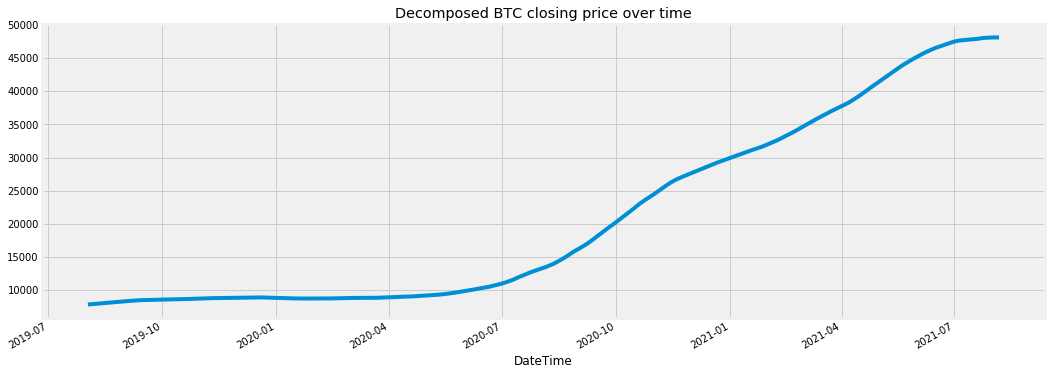

In [74]:
# The original non-stationary plot
decomposed_btc_close.trend.plot()
_ = plt.title('Decomposed BTC closing price over time')

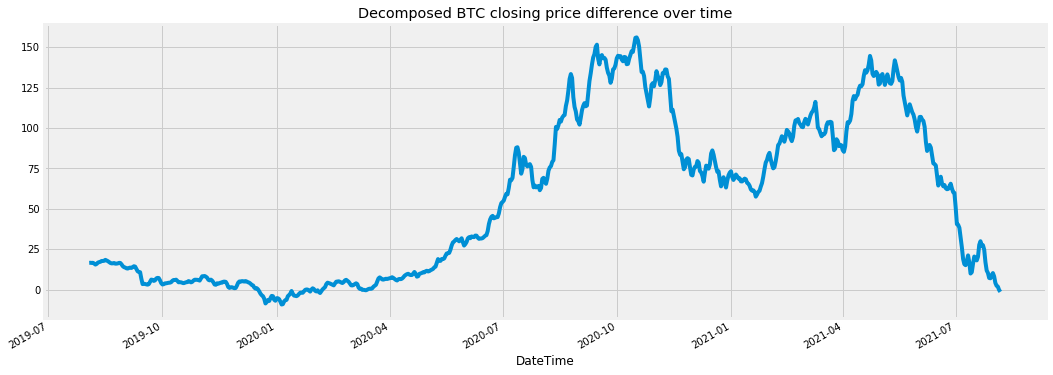

In [75]:
# The original non-stationary plot
decomposed_btc_close.trend.diff().plot()
_ = plt.title('Decomposed BTC closing price difference over time')

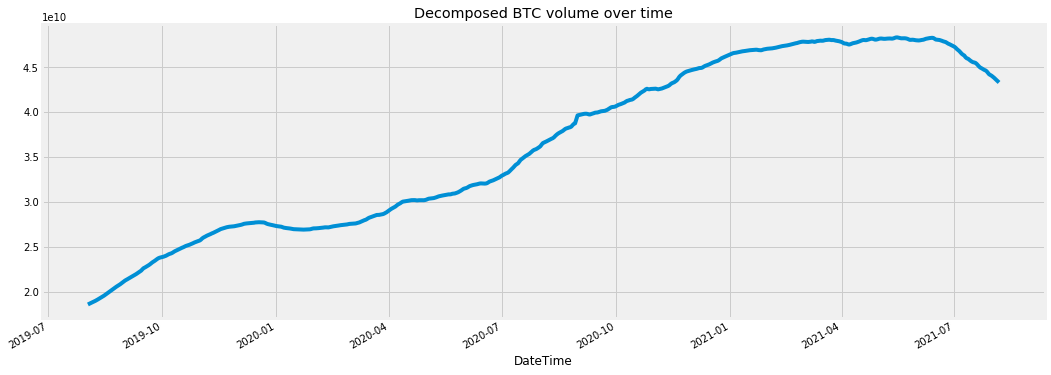

In [76]:
# The original non-stationary plot
decomposed_btc_volume.trend.plot()
_ = plt.title('Decomposed BTC volume over time')

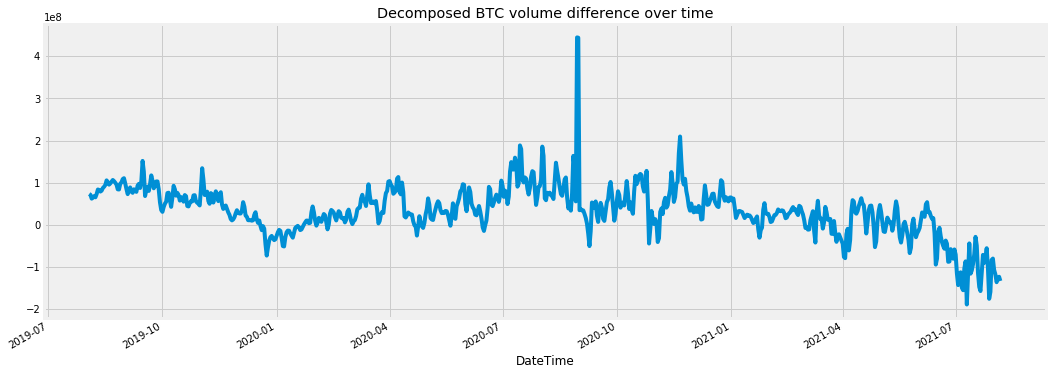

In [77]:
# The original non-stationary plot
decomposed_btc_volume.trend.diff().plot()
_ = plt.title('Decomposed BTC volume difference over time')

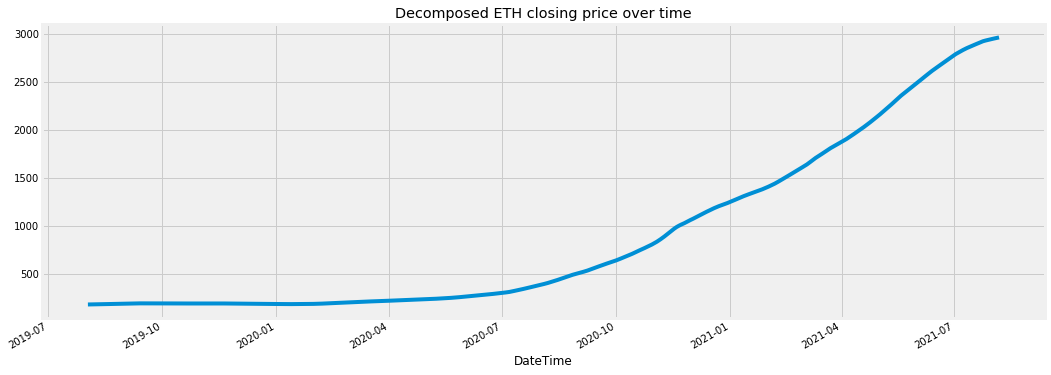

In [78]:
# The new stationary plot
decomposed_eth_close.trend.plot()
_ = plt.title('Decomposed ETH closing price over time')

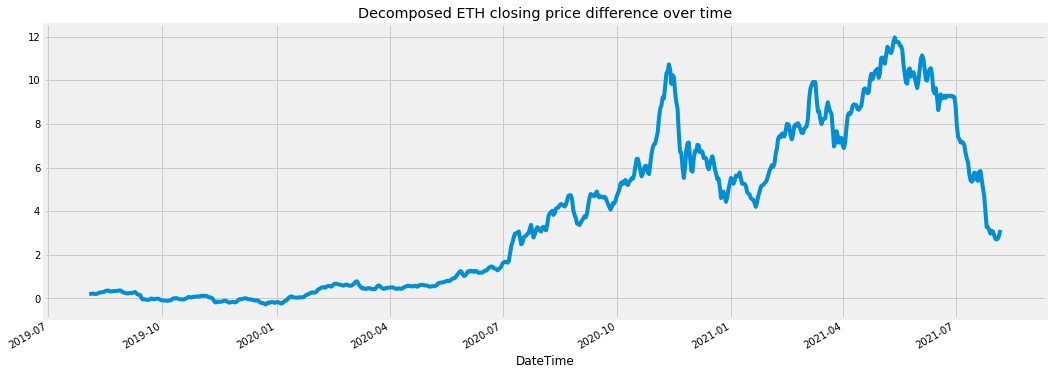

In [79]:
# The new stationary plot
decomposed_eth_close.trend.diff().plot()
_ = plt.title('Decomposed ETH closing price difference over time')

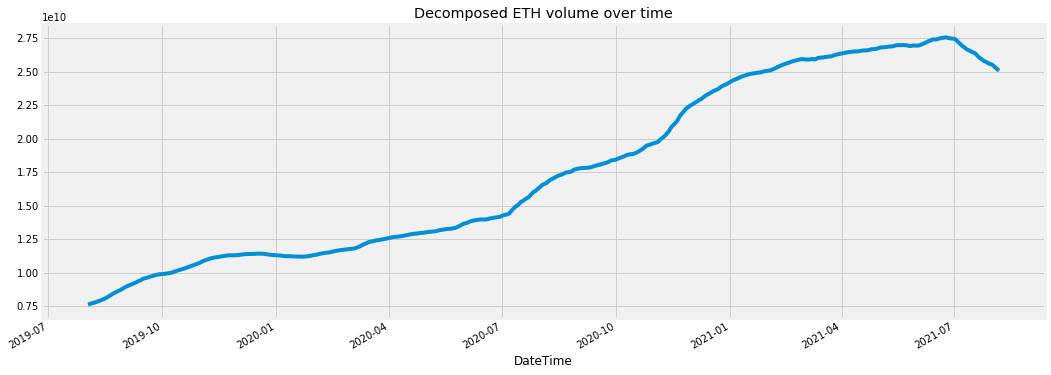

In [80]:
# The new stationary plot
decomposed_eth_volume.trend.plot()
_ = plt.title('Decomposed ETH volume over time')

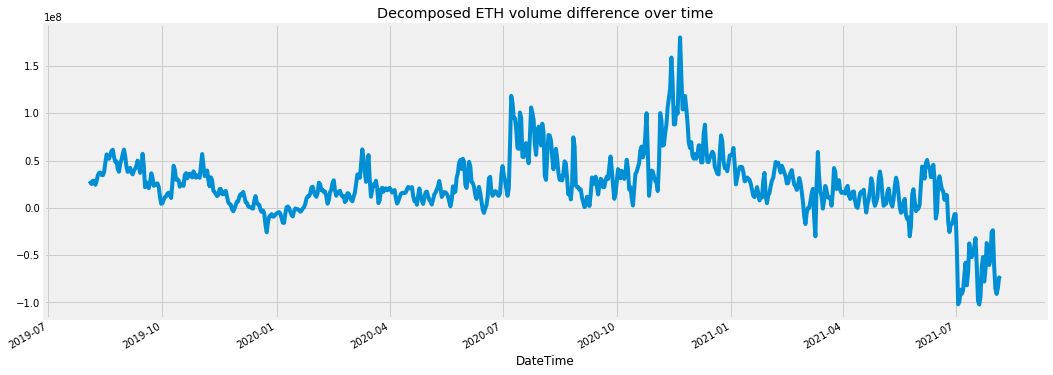

In [81]:
# The new stationary plot
decomposed_eth_volume.trend.diff().plot()
_ = plt.title('Decomposed ETH volume difference over time')

# <a id='4'>4. Modelling using statstools</a>

## <a id='4.1'>4.1 AR models</a>
 An autoregressive (AR) model is a representation of a type of random process; as such, it is used to describe certain time-varying processes in nature, economics, etc. The autoregressive model specifies that the output variable depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term); thus the model is in the form of a stochastic difference equation.
 #### AR(1) model
 R<sub>t</sub> = μ + ϕR<sub>t-1</sub> + ε<sub>t</sub>
 ##### As RHS has only one lagged value(R<sub>t-1</sub>)this is called AR model of order 1 where μ is mean and ε is noise at time t
 If ϕ = 1, it is random walk. Else if ϕ = 0, it is white noise. Else if -1 < ϕ < 1, it is stationary. If ϕ is -ve, there is men reversion. If ϕ is +ve, there is momentum.
 #### AR(2) model
 R<sub>t</sub> = μ + ϕ<sub>1</sub>R<sub>t-1</sub> + ϕ<sub>2</sub>R<sub>t-2</sub> + ε<sub>t</sub>
 #### AR(3) model
 R<sub>t</sub> = μ + ϕ<sub>1</sub>R<sub>t-1</sub> + ϕ<sub>2</sub>R<sub>t-2</sub> + ϕ<sub>3</sub>R<sub>t-3</sub> + ε<sub>t</sub>

## Simulating AR(1) model

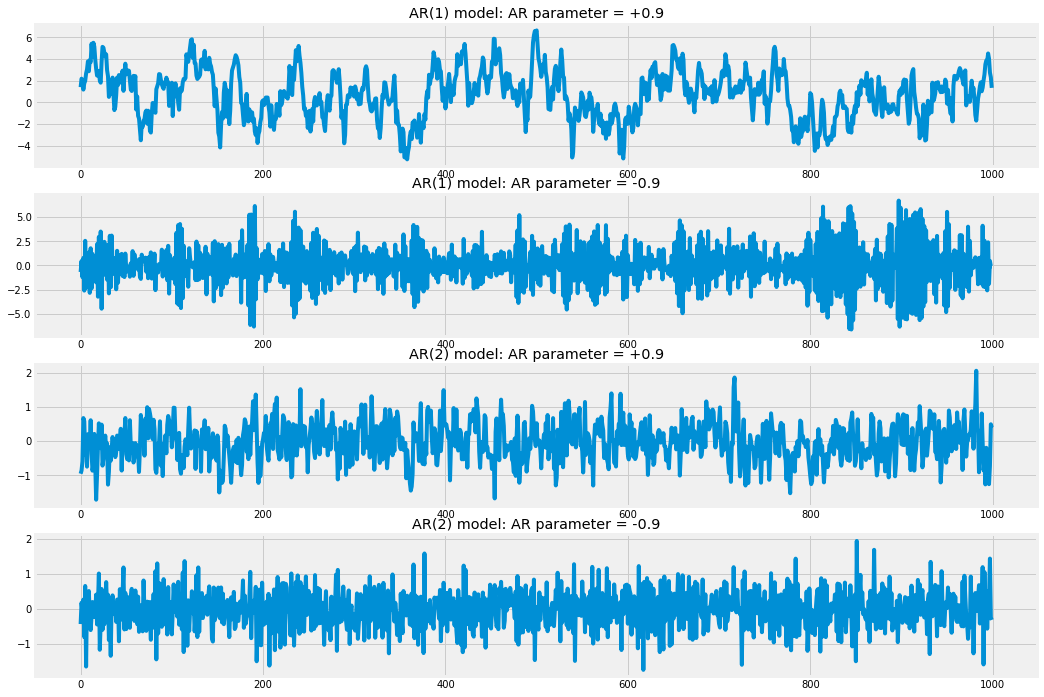

In [82]:
# AR(1) MA(1) model:AR parameter = +0.9
rcParams['figure.figsize'] = 16, 12
plt.subplot(4,1,1)
ar1 = np.array([1, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma1 = np.array([1])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = +0.9')
plt.plot(sim1)
# We will take care of MA model later
# AR(1) MA(1) AR parameter = -0.9
plt.subplot(4,1,2)
ar2 = np.array([1, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma2 = np.array([1])
AR2 = ArmaProcess(ar2, ma2)
sim2 = AR2.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = -0.9')
plt.plot(sim2)
# AR(2) MA(1) AR parameter = 0.9
plt.subplot(4,1,3)
ar3 = np.array([2, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma3 = np.array([1])
AR3 = ArmaProcess(ar3, ma3)
sim3 = AR3.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = +0.9')
plt.plot(sim3)
# AR(2) MA(1) AR parameter = -0.9
plt.subplot(4,1,4)
ar4 = np.array([2, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma4 = np.array([1])
AR4 = ArmaProcess(ar4, ma4)
sim4 = AR4.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = -0.9')
plt.plot(sim4)
plt.show()

## Forecasting a simulated model

In [83]:
model = ARMA(sim1, order=(1,0))
result = model.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1415.701
Method:                       css-mle   S.D. of innovations              0.996
Date:                Wed, 02 Feb 2022   AIC                           2837.403
Time:                        08:43:58   BIC                           2852.126
Sample:                             0   HQIC                          2842.998
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7072      0.288      2.454      0.014       0.142       1.272
ar.L1.y        0.8916      0.014     62.742      0.000       0.864       0.919
                                    Roots           

ϕ is around 0.9 which is what we chose as AR parameter in our first simulated model.

## Predicting the models

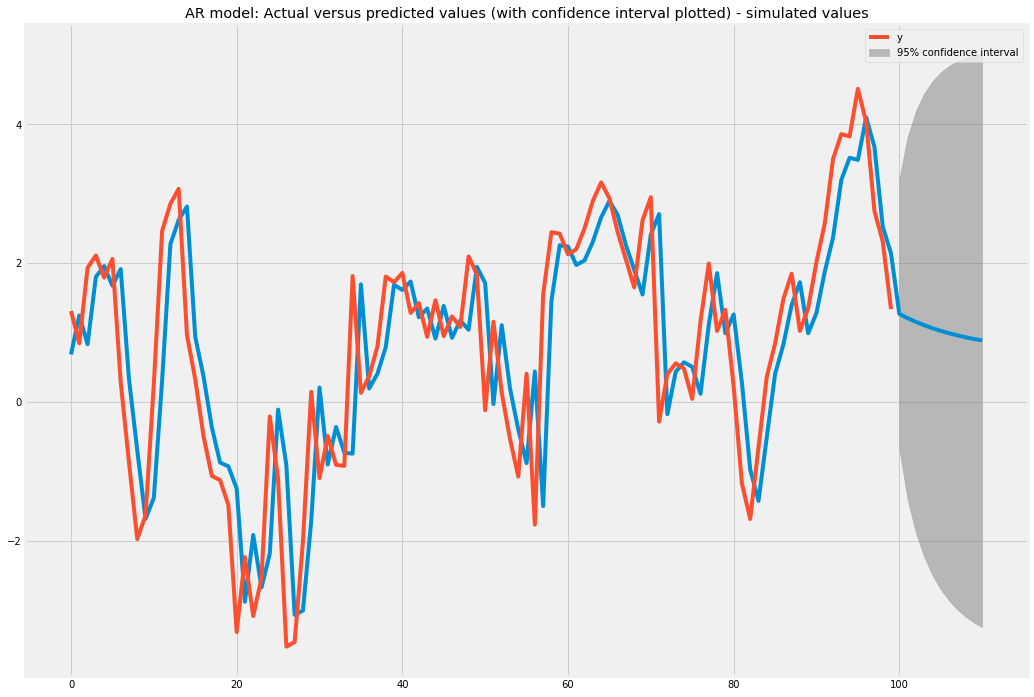

In [84]:
# Predicting simulated AR(1) model 
result.plot_predict(start=900, end=1010)
_ = plt.title('AR model: Actual versus predicted values (with confidence interval plotted) - simulated values')
plt.show()

In [85]:
rmse = math.sqrt(mean_squared_error(sim1[900:1011], result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 1.0408054544358292.


y is predicted plot. Quite neat!

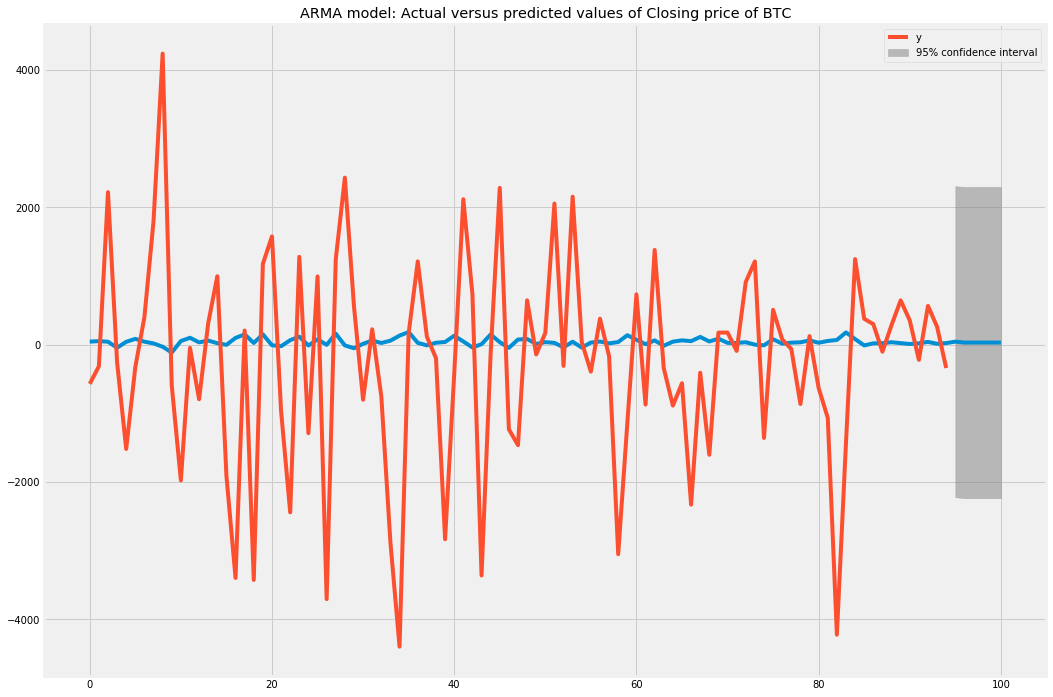

In [86]:
# Predicting Close price of BTC
close_price = ARMA(btc["Close"].diff().iloc[1:].values, order=(1,0))
res = close_price.fit()
res.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: Actual versus predicted values of Closing price of BTC')
plt.show()

In [87]:
rmse = math.sqrt(mean_squared_error(btc["Close"].diff().iloc[900:1000].values, result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 1751.7662897360958.


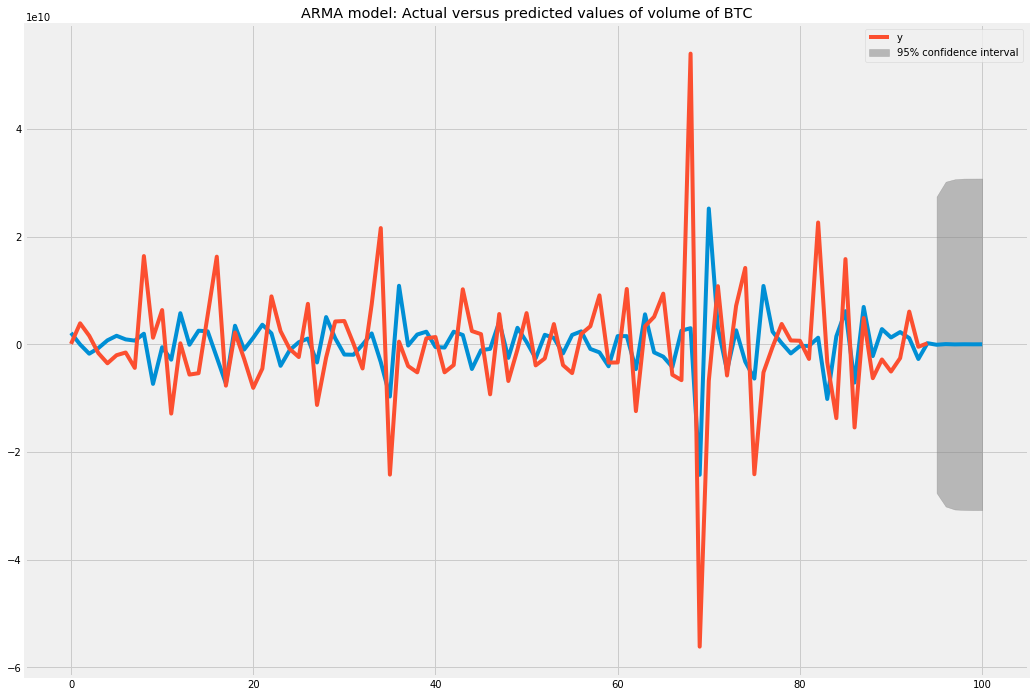

In [88]:
# Predicting Volume of BTC
volume = ARMA(btc["Volume"].diff().iloc[1:].values, order=(1,0))
res = volume.fit()
res.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: Actual versus predicted values of volume of BTC')
plt.show()

In [89]:
rmse = math.sqrt(mean_squared_error(btc["Volume"].diff().iloc[900:1000].values, result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 7849519402.8882885.


 Not quite impressive. But let's try Ethereum. 

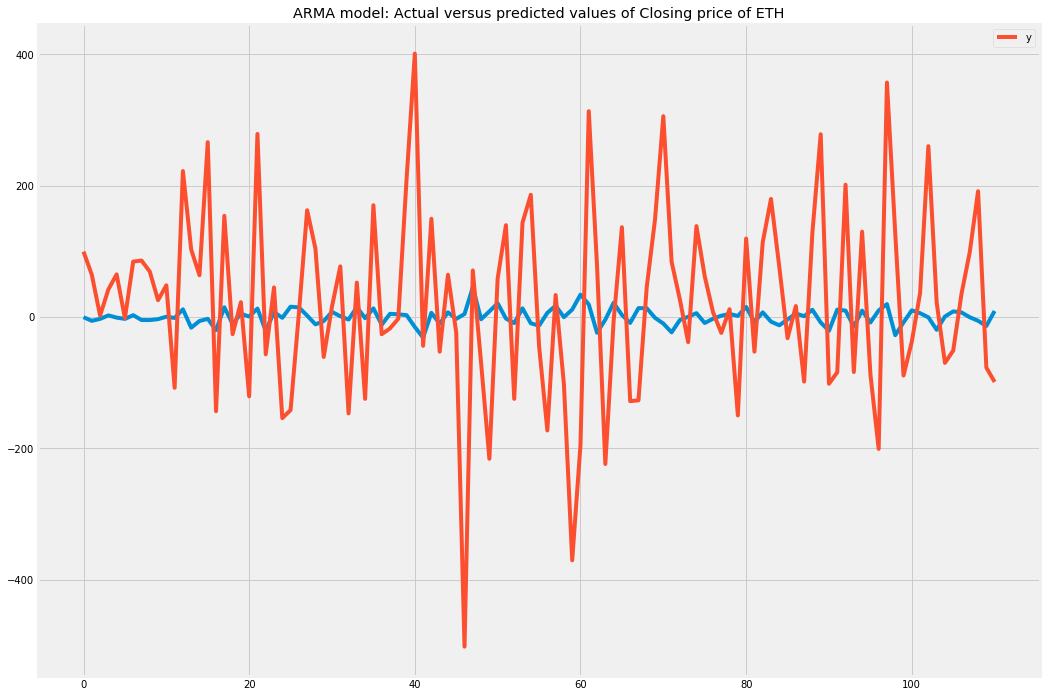

In [90]:
# Predicting closing prices of ETH
close_price = ARMA(eth["Close"].diff().iloc[1:].values, order=(1,0))
res = close_price.fit()
res.plot_predict(start=900, end=1010)
_ = plt.title('ARMA model: Actual versus predicted values of Closing price of ETH')
plt.show()

In [91]:
rmse = math.sqrt(mean_squared_error(eth["Close"].diff().iloc[900:1000].values, result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 147.50311916130408.


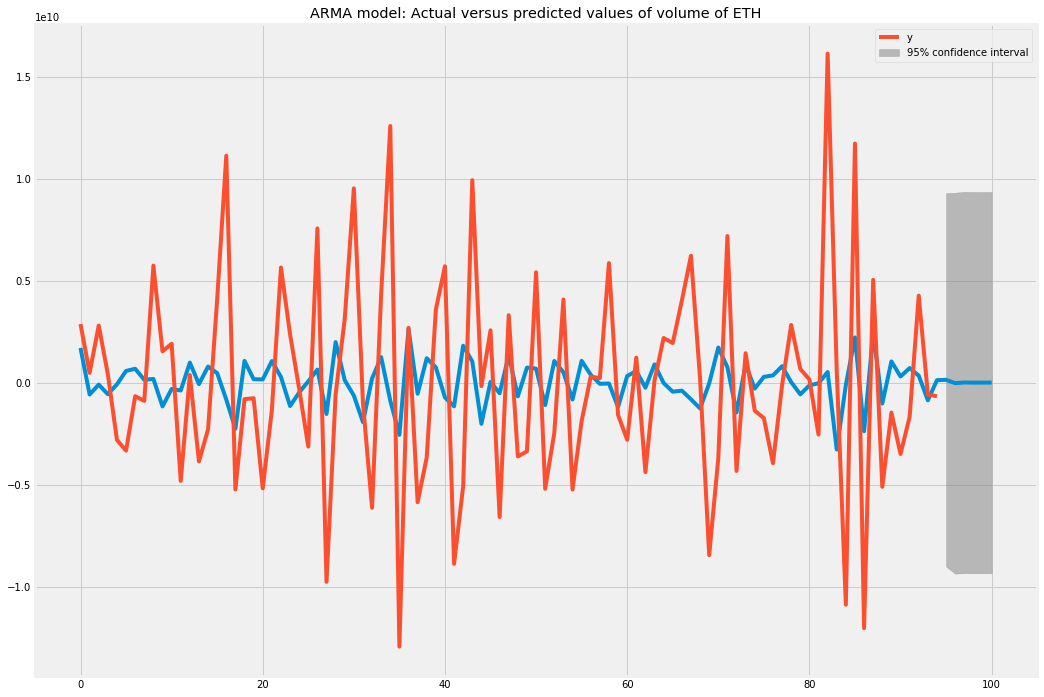

In [92]:
# Predicting Volume of ETH
volume = ARMA(eth["Volume"].diff().iloc[1:].values, order=(1,0))
res = volume.fit()
res.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: Actual versus predicted values of volume of ETH')
plt.show()

In [93]:
rmse = math.sqrt(mean_squared_error(eth["Volume"].diff().iloc[900:1000].values, result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 4722911518.534129.


There are always better models.

## <a id='4.2'>4.2 MA models</a>
The moving-average (MA) model is a common approach for modeling univariate time series. The moving-average model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.
#### MA(1) model
R<sub>t</sub> = μ  +  ϵ<sub>t</sub>1 + θϵ<sub>t-1</sub>

It translates to Today's returns = mean + today's noise + yesterday's noise
##### As there is only 1 lagged value in RHS, it is an MA model of order 1

## Simulating MA(1) model

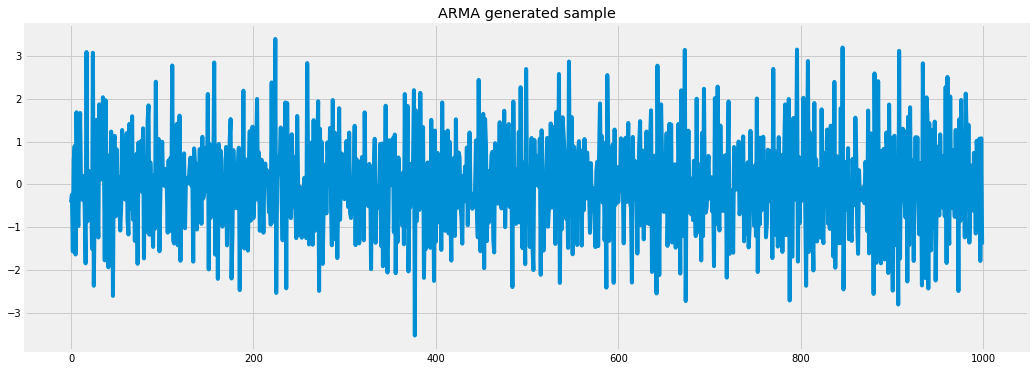

In [94]:
rcParams['figure.figsize'] = 16, 6
ar1 = np.array([1])
ma1 = np.array([1, -0.5])
MA1 = ArmaProcess(ar1, ma1)
sim1 = MA1.generate_sample(nsample=1000)
_ = plt.title('ARMA generated sample')
plt.plot(sim1)

## Forecasting the simulated MA model

In [95]:
model = ARMA(sim1, order=(0,1))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1423.276
Method:                       css-mle   S.D. of innovations              1.004
Date:                Wed, 02 Feb 2022   AIC                           2852.553
Time:                        08:44:00   BIC                           2867.276
Sample:                             0   HQIC                          2858.148
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0228      0.014     -1.652      0.099      -0.050       0.004
ma.L1.y       -0.5650      0.027    -20.797      0.000      -0.618      -0.512
                                    Roots           

## Prediction using MA models

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1095
Model:                     ARMA(0, 3)   Log Likelihood               -9275.883
Method:                       css-mle   S.D. of innovations           1155.382
Date:                Wed, 02 Feb 2022   AIC                          18561.766
Time:                        08:44:00   BIC                          18586.758
Sample:                             0   HQIC                         18571.223
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.9088     34.290      0.931      0.352     -35.298      99.115
ma.L1.y       -0.0358      0.030     -1.178      0.239      -0.095       0.024
ma.L2.y        0.0061      0.029      0.214      0.8

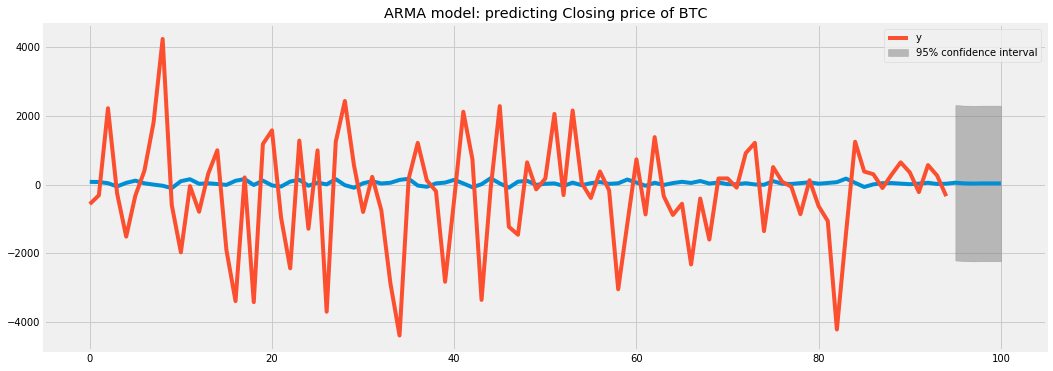

In [96]:
# Forecasting and predicting Closing price of BTC
model = ARMA(btc["Close"].diff().iloc[1:].values, order=(0,3))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))
result.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: predicting Closing price of BTC')
plt.show()

In [97]:
count = len(btc["Close"].diff().iloc[1000:1101].values)
rmse = math.sqrt(mean_squared_error(btc["Close"].diff().iloc[1000:1101].values, result.predict(start=1000,end=999+count)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 1595.1923014507286.


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1095
Model:                     ARMA(0, 1)   Log Likelihood              -27016.144
Method:                       css-mle   S.D. of innovations    12548765659.921
Date:                Wed, 02 Feb 2022   AIC                          54038.288
Time:                        08:44:01   BIC                          54053.283
Sample:                             0   HQIC                         54043.962
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.411e+07   7.91e+07      0.178      0.859   -1.41e+08    1.69e+08
ma.L1.y       -0.7921      0.022    -35.807      0.000      -0.835      -0.749
                                    Roots           

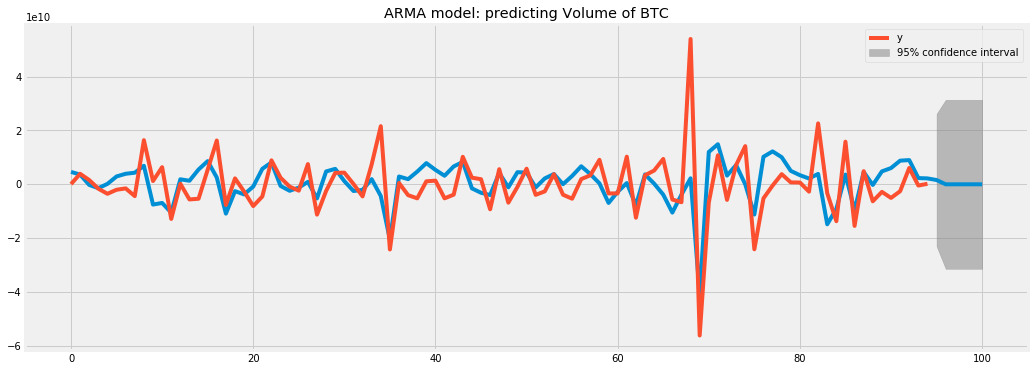

In [98]:
# Forecasting and predicting Volume of BTC
model = ARMA(btc["Volume"].diff().iloc[1:].values, order=(0,1)) # changed q from 3 to 1 to resolve error https://stackoverflow.com/questions/52815990/valueerror-the-computed-initial-ma-coefficients-are-not-invertible-you-should-i
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))
result.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: predicting Volume of BTC')
plt.show()

In [99]:
count = len(btc["Volume"].diff().iloc[1000:1101].values)
rmse = math.sqrt(mean_squared_error(btc["Volume"].diff().iloc[1000:1101].values, result.predict(start=1000,end=999+count)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 17479904263.880165.


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1095
Model:                     ARMA(0, 3)   Log Likelihood               -6469.813
Method:                       css-mle   S.D. of innovations             89.082
Date:                Wed, 02 Feb 2022   AIC                          12949.626
Time:                        08:44:01   BIC                          12974.618
Sample:                             0   HQIC                         12959.083
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4278      2.577      0.942      0.346      -2.624       7.480
ma.L1.y       -0.0858      0.030     -2.835      0.005      -0.145      -0.026
ma.L2.y        0.0253      0.029      0.872      0.3

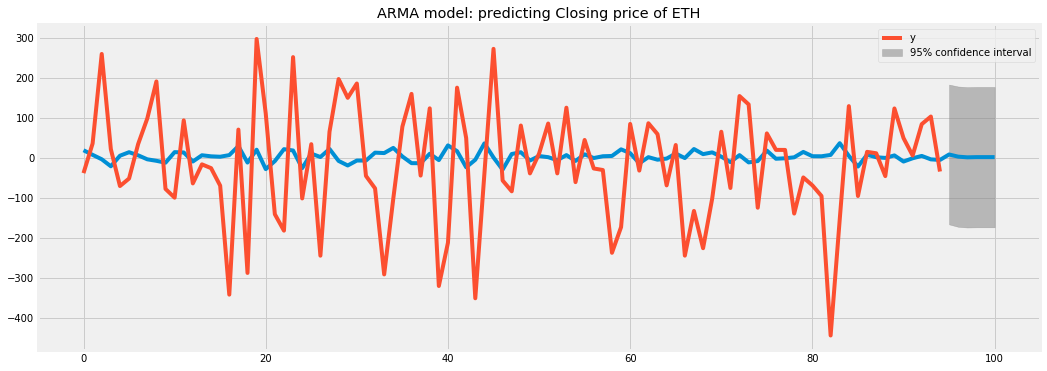

In [100]:
# Forecasting and predicting Closing price of ETH
model = ARMA(eth["Close"].diff().iloc[1:].values, order=(0,3))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))
result.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: predicting Closing price of ETH')
plt.show()

In [101]:
samples = eth["Close"].diff().iloc[1000:1101].values
count = len(samples)
rmse = math.sqrt(mean_squared_error(samples, result.predict(start=1000,end=999+count)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 156.69785628807577.


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1095
Model:                     ARMA(0, 1)   Log Likelihood              -25900.725
Method:                       css-mle   S.D. of innovations     4532603700.786
Date:                Wed, 02 Feb 2022   AIC                          51807.450
Time:                        08:44:02   BIC                          51822.446
Sample:                             0   HQIC                         51813.125
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.149e+06    6.9e+07      0.133      0.895   -1.26e+08    1.44e+08
ma.L1.y       -0.4968      0.040    -12.482      0.000      -0.575      -0.419
                                    Roots           

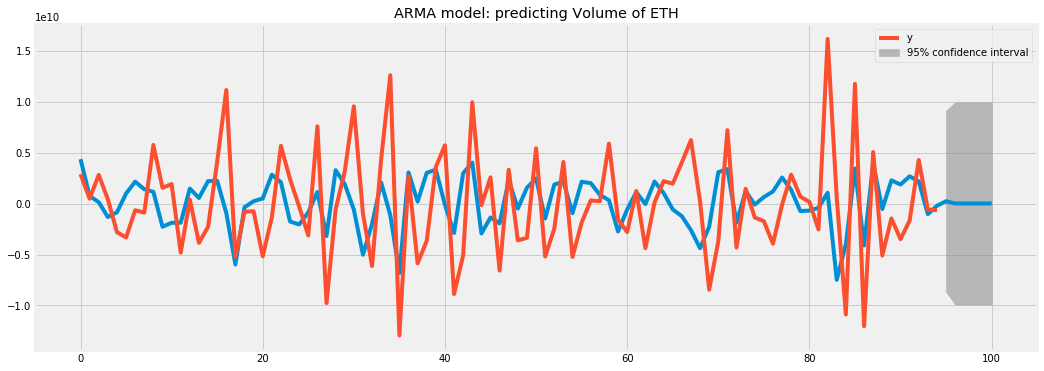

CPU times: user 487 ms, sys: 455 ms, total: 942 ms
Wall time: 268 ms


In [102]:
%%time
# Forecasting and predicting Volume of ETH
model = ARMA(eth["Volume"].diff().iloc[1:].values, order=(0,1)) # changed q from 3 to 1 to resolve error https://stackoverflow.com/questions/52815990/valueerror-the-computed-initial-ma-coefficients-are-not-invertible-you-should-i
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))
result.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: predicting Volume of ETH')
plt.show()

In [103]:
samples = eth["Volume"].diff().iloc[1000:1101].values
count = len(samples)
rmse = math.sqrt(mean_squared_error(samples, result.predict(start=1000,end=999+count)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 7472936894.471859.


Now, for ARMA models.

## <a id='4.3'>4.3 ARMA models</a>
Autoregressive–moving-average (ARMA) models provide a parsimonious description of a (weakly) stationary stochastic process in terms of two polynomials, one for the autoregression and the second for the moving average. It's the fusion of AR and MA models.
### ARMA(1,1) model
### R<sub>t</sub> = μ + ϕR<sub>t-1</sub> + ϵ<sub>t</sub> + θϵ<sub>t-1</sub> 
Basically, Today's return = mean + Yesterday's return + noise + yesterday's noise.

## Prediction using ARMA models
I am not simulating any model because it's quite similar to AR and MA models. Just  forecasting and predictions for this one.

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1095
Model:                     ARMA(3, 2)   Log Likelihood               -9275.010
Method:                       css-mle   S.D. of innovations           1154.453
Date:                Wed, 02 Feb 2022   AIC                          18564.020
Time:                        08:44:03   BIC                          18599.010
Sample:                             0   HQIC                         18577.260
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.7864     43.123      0.714      0.475     -53.733     115.306
ar.L1.y        0.1715      0.423      0.405      0.685      -0.658       1.001
ar.L2.y        0.7380      0.378      1.950      0.0

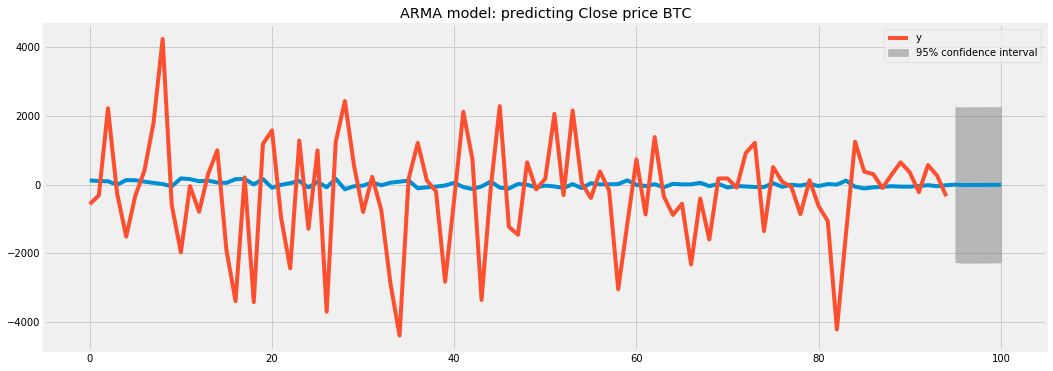

CPU times: user 2.66 s, sys: 1.9 s, total: 4.56 s
Wall time: 1.63 s


In [104]:
%%time
# Forecasting and predicting Closing price of BTC 
model = ARMA(btc["Close"].diff().iloc[1:].values, order=(3,2))
result = model.fit()
print(result.summary())
print("μ={}, ϕ={}, θ={}".format(result.params[0],result.params[1],result.params[2]))
result.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: predicting Close price BTC')
plt.show()

In [105]:
samples = btc["Close"].diff().iloc[1000:1101].values
count = len(samples)
rmse = math.sqrt(mean_squared_error(samples, result.predict(start=1000,end=999+count)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 1587.992525018966.


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1095
Model:                     ARMA(3, 3)   Log Likelihood              -27009.302
Method:                       css-mle   S.D. of innovations    12469388828.238
Date:                Wed, 02 Feb 2022   AIC                          54034.604
Time:                        08:44:05   BIC                          54074.592
Sample:                             0   HQIC                         54049.735
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.411e+07   7.38e+07      0.191      0.848    -1.3e+08    1.59e+08
ar.L1.y       -1.3225      0.057    -23.053      0.000      -1.435      -1.210
ar.L2.y       -0.8752      0.064    -13.640      0.0

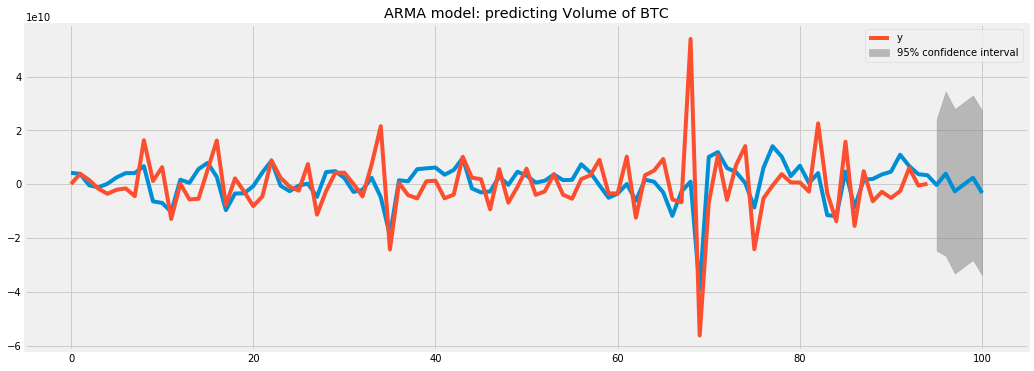

CPU times: user 2.94 s, sys: 2.28 s, total: 5.22 s
Wall time: 1.85 s


In [106]:
%%time
# Forecasting and predicting BTC volume
model = ARMA(btc["Volume"].diff().iloc[1:].values, order=(3,3))
result = model.fit()
print(result.summary())
print("μ={}, ϕ={}, θ={}".format(result.params[0],result.params[1],result.params[2]))
result.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: predicting Volume of BTC')
plt.show()

In [107]:
samples = btc["Volume"].diff().iloc[1000:1101].values
count = len(samples)
rmse = math.sqrt(mean_squared_error(samples, result.predict(start=1000,end=999+count)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 16813321985.069761.


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1095
Model:                     ARMA(3, 3)   Log Likelihood              -25851.622
Method:                       css-mle   S.D. of innovations     4333368631.537
Date:                Wed, 02 Feb 2022   AIC                          51719.244
Time:                        08:44:06   BIC                          51759.232
Sample:                             0   HQIC                         51734.375
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.149e+06   4.52e+07      0.203      0.840   -7.94e+07    9.77e+07
ar.L1.y       -0.1278      0.119     -1.070      0.285      -0.362       0.106
ar.L2.y       -0.6296      0.081     -7.820      0.0

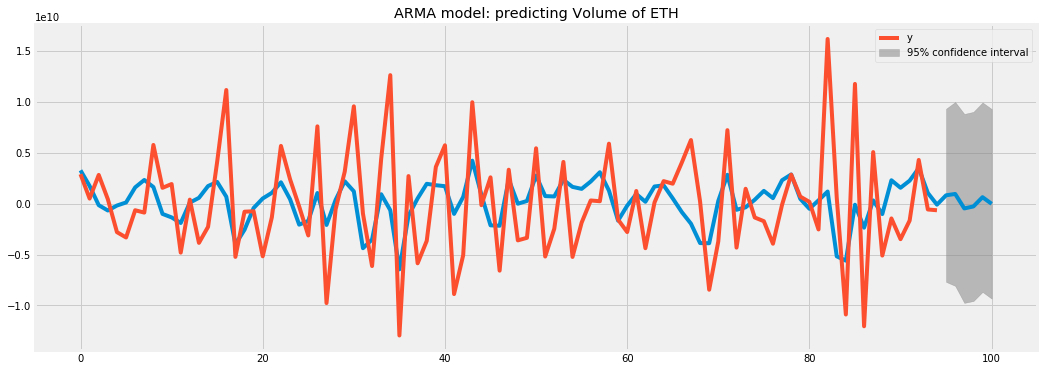

CPU times: user 2.29 s, sys: 1.88 s, total: 4.17 s
Wall time: 1.34 s


In [108]:
%%time
# Forecasting and predicting ETH volume
model = ARMA(eth["Volume"].diff().iloc[1:].values, order=(3,3))
result = model.fit()
print(result.summary())
print("μ={}, ϕ={}, θ={}".format(result.params[0],result.params[1],result.params[2]))
result.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: predicting Volume of ETH')
plt.show()

In [109]:
samples = eth["Volume"].diff().iloc[1000:1101].values
count = len(samples)
rmse = math.sqrt(mean_squared_error(samples, result.predict(start=1000,end=999+count)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 6543458042.594244.


ARMA model shows much better results than AR and MA models.

## <a id='4.4'>4.4 ARIMA models</a>
An autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity.
ARIMA model is of the form: ARIMA(p,d,q): p is AR parameter, d is differential parameter, q is MA parameter
### ARIMA(1,0,0)
**y<sub>t</sub> = a<sub>1</sub>y<sub>t-1</sub> + ϵ<sub>t</sub>**
### ARIMA(1,0,1)
**y<sub>t</sub> = a<sub>1</sub>y<sub>t-1</sub> + ϵ<sub>t</sub> + b<sub>1</sub>ϵ<sub>t-1</sub>**
### ARIMA(1,1,1)
**Δy<sub>t</sub> = a<sub>1</sub>Δy<sub>t-1</sub> + ϵ<sub>t</sub> + b<sub>1</sub>ϵ<sub>t-1</sub>** where **Δy<sub>t</sub> = y<sub>t</sub> - y<sub>t-1</sub>**

## Prediction using ARIMA model

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1094
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -9425.224
Method:                       css-mle   S.D. of innovations           1334.325
Date:                Wed, 02 Feb 2022   AIC                          18858.448
Time:                        08:44:07   BIC                          18878.438
Sample:                             1   HQIC                         18866.013
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050     19.767      0.000      1.000     -38.737      38.747
ar.L1.D.y     -0.6985      0.028    -24.615      0.000      -0.754      -0.643
ar.L2.D.y     -0.3436      0.028    -12.118      0.0

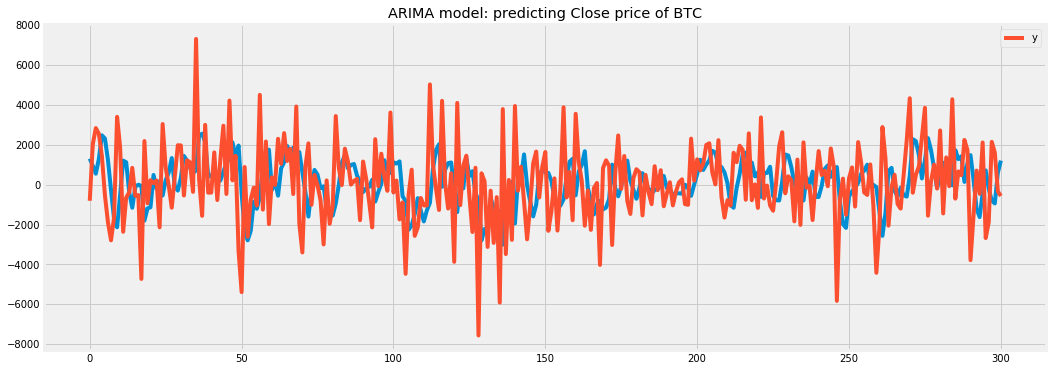

CPU times: user 715 ms, sys: 548 ms, total: 1.26 s
Wall time: 408 ms


In [110]:
%%time
# Predicting the close price of BTC 
rcParams['figure.figsize'] = 16, 6
model = ARIMA(btc["Close"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
_ = plt.title('ARIMA model: predicting Close price of BTC')
plt.show()

In [111]:
rmse = math.sqrt(mean_squared_error(btc["Close"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 3442.017266010057.


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1094
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -27375.477
Method:                       css-mle   S.D. of innovations    17824432543.196
Date:                Wed, 02 Feb 2022   AIC                          54758.954
Time:                        08:44:07   BIC                          54778.945
Sample:                             1   HQIC                         54766.519
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.785e+04   2.18e+08     -0.000      1.000   -4.28e+08    4.28e+08
ar.L1.D.y     -0.9512      0.026    -36.834      0.000      -1.002      -0.901
ar.L2.D.y     -0.5181      0.026    -20.079      0.0

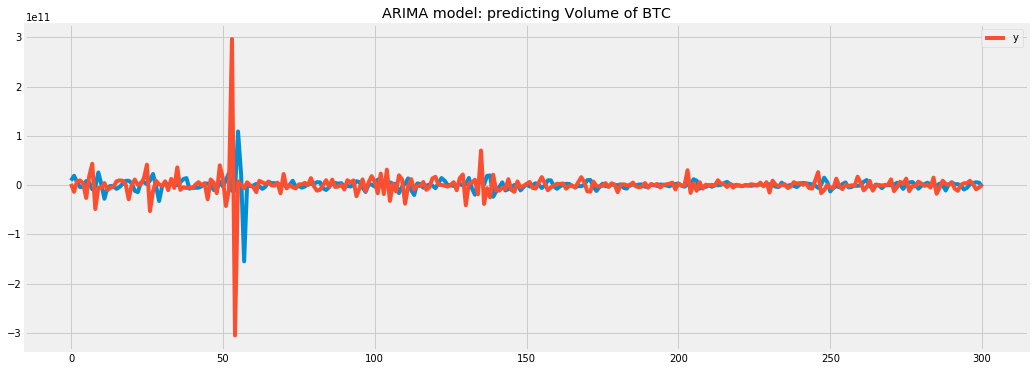

CPU times: user 893 ms, sys: 763 ms, total: 1.66 s
Wall time: 496 ms


In [112]:
%%time
# Predicting the BTC volume
rcParams['figure.figsize'] = 16, 6
model = ARIMA(btc["Volume"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
_ = plt.title('ARIMA model: predicting Volume of BTC')
plt.show()

In [113]:
rmse = math.sqrt(mean_squared_error(btc["Volume"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 61589694463.50726.


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1094
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -6623.389
Method:                       css-mle   S.D. of innovations            103.034
Date:                Wed, 02 Feb 2022   AIC                          13254.778
Time:                        08:44:08   BIC                          13274.768
Sample:                             1   HQIC                         13262.342
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0325      1.488      0.022      0.983      -2.884       2.949
ar.L1.D.y     -0.7434      0.028    -26.264      0.000      -0.799      -0.688
ar.L2.D.y     -0.3513      0.028    -12.420      0.0

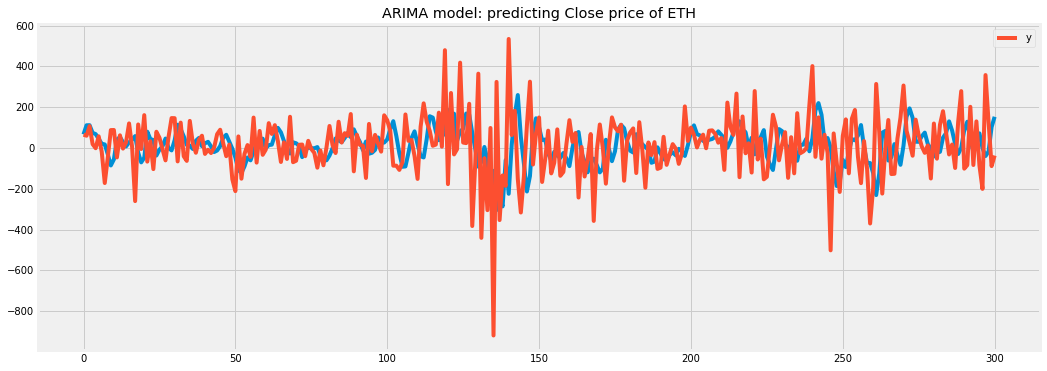

CPU times: user 808 ms, sys: 631 ms, total: 1.44 s
Wall time: 465 ms


In [114]:
%%time
# Predicting the Close price of ETH 
rcParams['figure.figsize'] = 16, 6
model = ARIMA(eth["Close"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
_ = plt.title('ARIMA model: predicting Close price of ETH')
plt.show()

In [115]:
rmse = math.sqrt(mean_squared_error(eth["Close"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 273.6515805385165.


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1094
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -26156.707
Method:                       css-mle   S.D. of innovations     5851699934.578
Date:                Wed, 02 Feb 2022   AIC                          52321.414
Time:                        08:44:08   BIC                          52341.405
Sample:                             1   HQIC                         52328.979
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -5.76e+05   8.36e+07     -0.007      0.995   -1.65e+08    1.63e+08
ar.L1.D.y     -0.7001      0.027    -25.489      0.000      -0.754      -0.646
ar.L2.D.y     -0.4164      0.027    -15.171      0.0

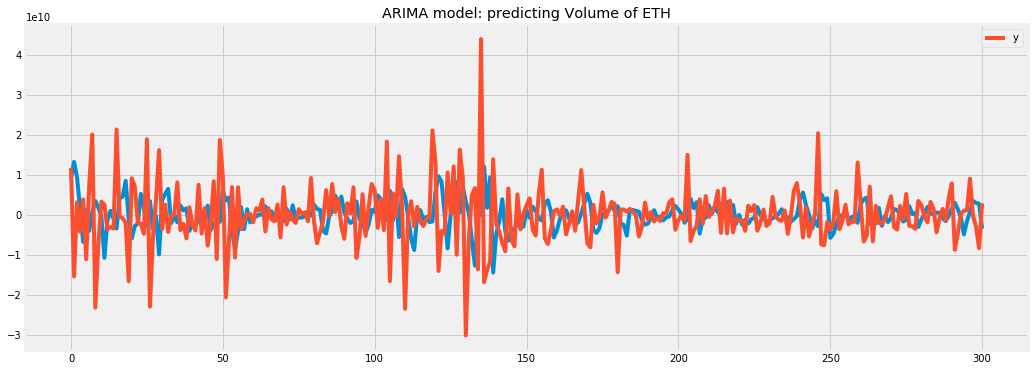

CPU times: user 704 ms, sys: 527 ms, total: 1.23 s
Wall time: 384 ms


In [116]:
%%time
# Predicting the ETH volume
rcParams['figure.figsize'] = 16, 6
model = ARIMA(eth["Volume"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
_ = plt.title('ARIMA model: predicting Volume of ETH')
plt.show()

In [117]:
rmse = math.sqrt(mean_squared_error(eth["Volume"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 14442382619.472092.


Taking the slight lag into account, this is a fine model.

## <a id='4.5'>4.5 VAR models</a>
Vector autoregression (VAR) is a stochastic process model used to capture the linear interdependencies among multiple time series. VAR models generalize the univariate autoregressive model (AR model) by allowing for more than one evolving variable. All variables in a VAR enter the model in the same way: each variable has an equation explaining its evolution based on its own lagged values, the lagged values of the other model variables, and an error term. VAR modeling does not require as much knowledge about the forces influencing a variable as do structural models with simultaneous equations: The only prior knowledge required is a list of variables which can be hypothesized to affect each other intertemporally.

<img src="https://miro.medium.com/max/1324/1*nMfvffr_-ktXuCwMq6I78g.png">
<img src="https://espin086.files.wordpress.com/2011/01/screenhunter_03-jan-16-15-14.gif">

In [118]:
# %%time
# # Predicting closing price of BTC and ETH
## Encountering error: LinAlgError: Singular forecast error covariance matrix encountered at period 133
# train_sample = pd.concat([btc["Close"].diff().iloc[1:], eth["Close"].diff().iloc[1:]],axis=1)
# model = sm.tsa.VARMAX(train_sample,order=(2,1),trend='c', enforce_invertibility=False, enforce_stationarity=False) 
# result = model.fit(maxiter=1000,disp=False)
# print(result.summary())
# predicted_result = result.predict(start=0, end=1000)
# result.plot_diagnostics()
# # calculating error
# rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
# print("The root mean squared error is {}.".format(rmse))

                            Statespace Model Results                            
Dep. Variable:     ['Volume', 'Volume']   No. Observations:                 1095
Model:                       VARMA(2,1)   Log Likelihood              -52676.156
                            + intercept   AIC                         105386.313
Date:                  Wed, 02 Feb 2022   BIC                         105471.287
Time:                          08:44:19   HQIC                        105418.466
Sample:                      02-04-2019                                         
                           - 02-02-2022                                         
Covariance Type:                    opg                                         
Ljung-Box (Q):                56.74, 97.31   Jarque-Bera (JB):   6304345.31, 7700.19
Prob(Q):                        0.04, 0.00   Prob(JB):                    0.00, 0.00
Heteroskedasticity (H):       24.11, 18.49   Skew:                       14.74, 1.66
Prob(H) (two-sid

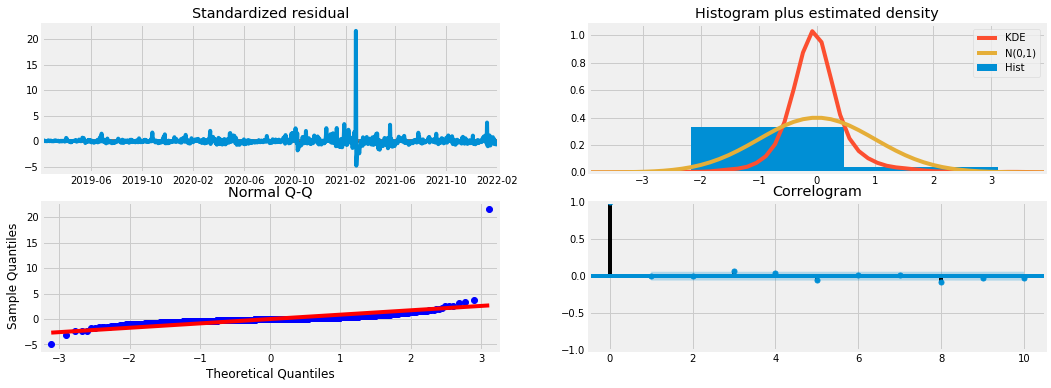

In [119]:
%%time
# Predicting Volume of BTC and ETH
train_sample = pd.concat([btc["Volume"].diff().iloc[1:], eth["Volume"].diff().iloc[1:]],axis=1)
model = sm.tsa.VARMAX(train_sample,order=(2,1),trend='c', enforce_invertibility=False, enforce_stationarity=False)
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=1000)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))

## <a id='4.6'>4.6 State Space methods</a>

A general state space model is of the form

y<sub>t</sub>=Z<sub>t</sub>α<sub>t</sub>+d<sub>t</sub>+ε<sub>t</sub>

α<sub>t</sub>=T<sub>t</sub>α<sub>t</sub>−1+c<sub>t</sub>+R<sub>t</sub>η<sub>t</sub>

where y<sub>t</sub> refers to the observation vector at time t, α<sub>t</sub> refers to the (unobserved) state vector at time t, and where the irregular components are defined as

ε<sub>t</sub>∼N(0,H<sub>t</sub>)

η<sub>t</sub>∼N(0,Q<sub>t</sub>)

The remaining variables (Z<sub>t</sub>,d<sub>t</sub>,H<sub>t</sub>,T<sub>t</sub>,c<sub>t</sub>,R<sub>t</sub>,Q<sub>t</sub>) in the equations are matrices describing the process. Their variable names and dimensions are as follows

Z : design (k_endog×k_states×nobs)

d : obs_intercept (k_endog×nobs)

H : obs_cov (k_endog×k_endog×nobs)

T : transition (k_states×k_states×nobs)

c : state_intercept (k_states×nobs)

R : selection (k_states×k_posdef×nobs)

Q : state_cov (k_posdef×k_posdef×nobs)

In the case that one of the matrices is time-invariant (so that, for example, Z<sub>t</sub>=Z<sub>t</sub>+1 ∀ <sub>t</sub>), its last dimension may be of size 1 rather than size nobs.

This generic form encapsulates many of the most popular linear time series models (see below) and is very flexible, allowing estimation with missing observations, forecasting, impulse response functions, and much more.

Source: [statsmodels](https://www.statsmodels.org/dev/statespace.html)

## <a id='4.6.1'>4.6.1 SARIMA models</a>
SARIMA models are useful for modeling seasonal time series, in which the mean and other statistics for a given season are not stationary across the years. The SARIMA model defined constitutes a straightforward extension of the nonseasonal autoregressive-moving average (ARMA) and autoregressive integrated moving average (ARIMA) models presented

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1095
Model:               SARIMAX(4, 0, 4)   Log Likelihood               -9233.509
Date:                Wed, 02 Feb 2022   AIC                          18487.018
Time:                        08:44:21   BIC                          18537.003
Sample:                             0   HQIC                         18505.932
                               - 1095                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     31.5196     73.457      0.429      0.668    -112.454     175.493
ar.L1          0.4440      0.634      0.700      0.484      -0.798       1.686
ar.L2         -0.4289      0.361     -1.189      0.2

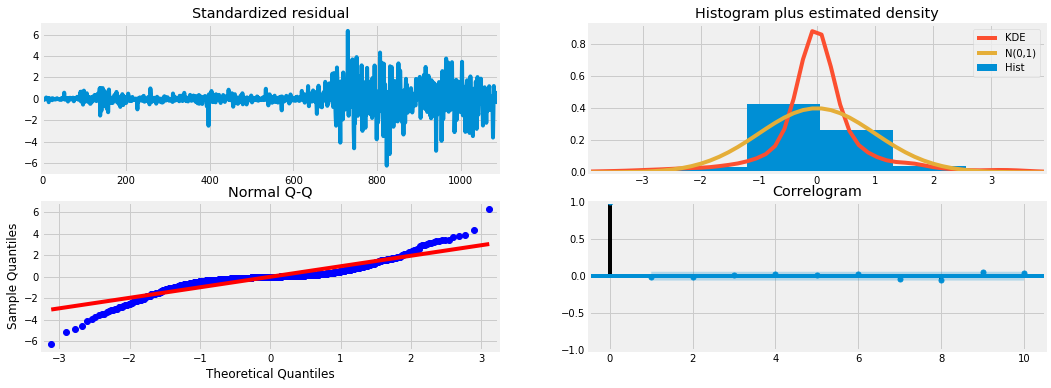

In [120]:
%%time
# Predicting closing price of BTC'
train_sample = btc["Close"].diff().iloc[1:].values

model = sm.tsa.SARIMAX(train_sample,order=(4,0,4),trend='c', enforce_invertibility=False, enforce_stationarity=False)
result = model.fit(maxiter=1000, disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

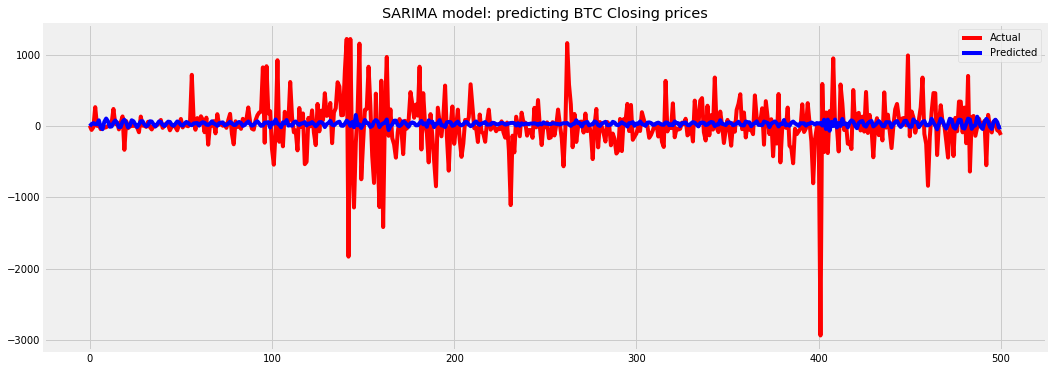

In [121]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('SARIMA model: predicting BTC Closing prices')
plt.show()

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1095
Model:               SARIMAX(4, 0, 4)   Log Likelihood              -26884.113
Date:                Wed, 02 Feb 2022   AIC                          53788.227
Time:                        08:44:24   BIC                          53838.212
Sample:                             0   HQIC                         53807.141
                               - 1095                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    5.92e+07   1.08e-07   5.46e+14      0.000    5.92e+07    5.92e+07
ar.L1         -0.3899      2.869     -0.136      0.892      -6.013       5.233
ar.L2         -0.9663      0.567     -1.704      0.0

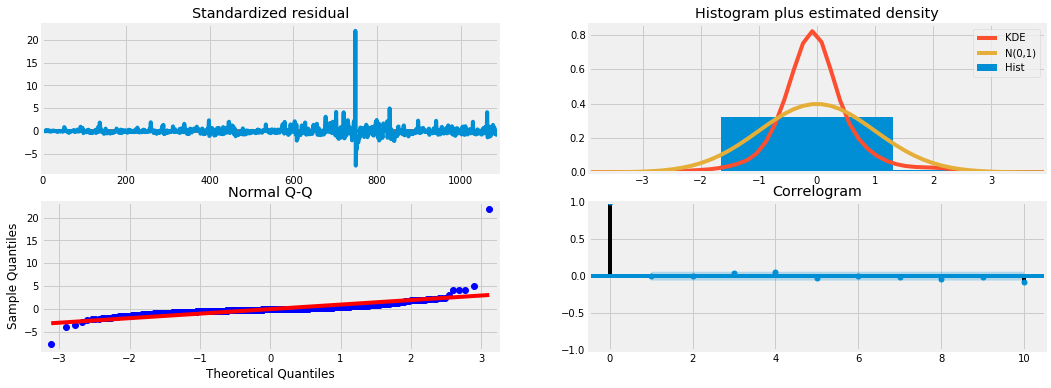

In [122]:
%%time
# Predicting Volume of BTC'
train_sample = btc["Volume"].diff().iloc[1:].values

model = sm.tsa.SARIMAX(train_sample,order=(4,0,4),trend='c', enforce_invertibility=False, enforce_stationarity=False)
result = model.fit(maxiter=1000, disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

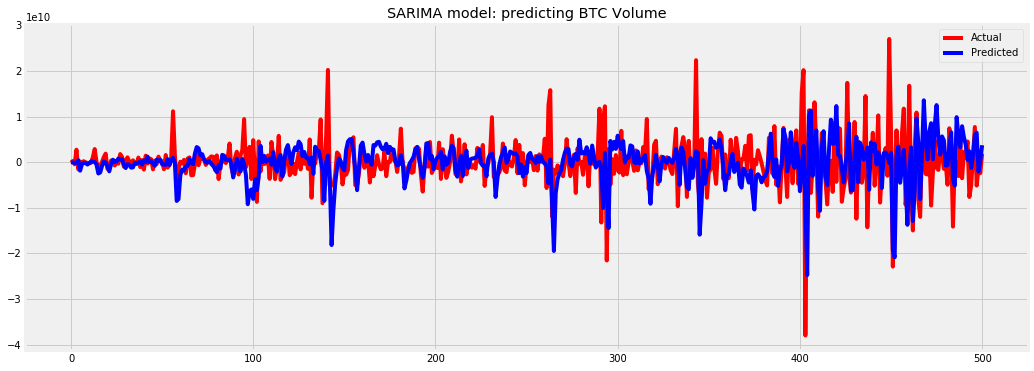

In [123]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('SARIMA model: predicting BTC Volume')
plt.show()

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1095
Model:               SARIMAX(4, 0, 4)   Log Likelihood               -6431.084
Date:                Wed, 02 Feb 2022   AIC                          12882.167
Time:                        08:44:27   BIC                          12932.152
Sample:                             0   HQIC                         12901.081
                               - 1095                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3887      5.001      0.478      0.633      -7.412      12.190
ar.L1         -0.7238      0.261     -2.771      0.006      -1.236      -0.212
ar.L2         -0.4529      0.378     -1.198      0.2

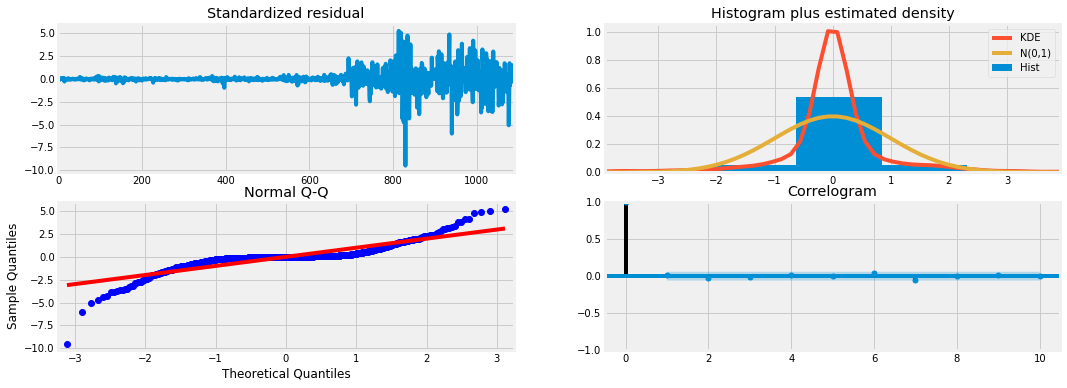

In [124]:
%%time
train_sample = eth["Close"].diff().iloc[1:].values
model = sm.tsa.SARIMAX(train_sample,order=(4,0,4),trend='c', enforce_invertibility=False, enforce_stationarity=False)
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

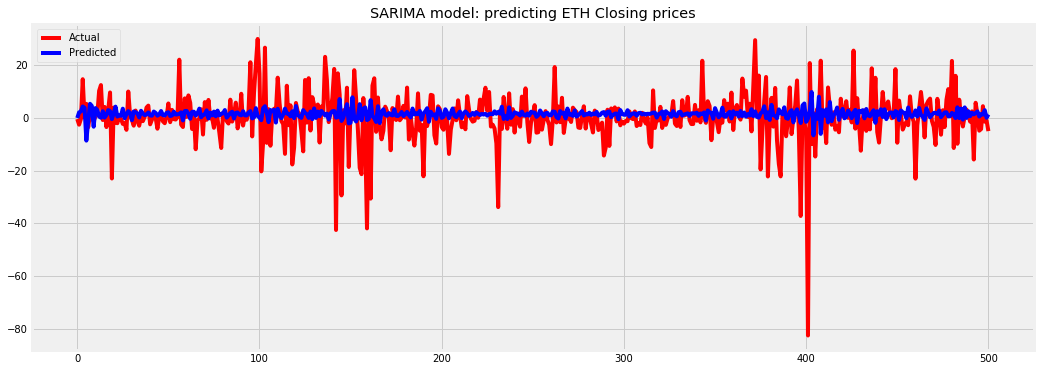

In [125]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('SARIMA model: predicting ETH Closing prices')
plt.show()

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1095
Model:               SARIMAX(4, 0, 4)   Log Likelihood           -11775162.940
Date:                Wed, 02 Feb 2022   AIC                       23550345.880
Time:                        08:44:32   BIC                       23550395.865
Sample:                             0   HQIC                      23550364.793
                               - 1095                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.918e+07   1.59e-07    1.2e+14      0.000    1.92e+07    1.92e+07
ar.L1       -303.8965      0.001  -4.71e+05      0.000    -303.898    -303.895
ar.L2       1084.4457      0.867   1251.225      0.0

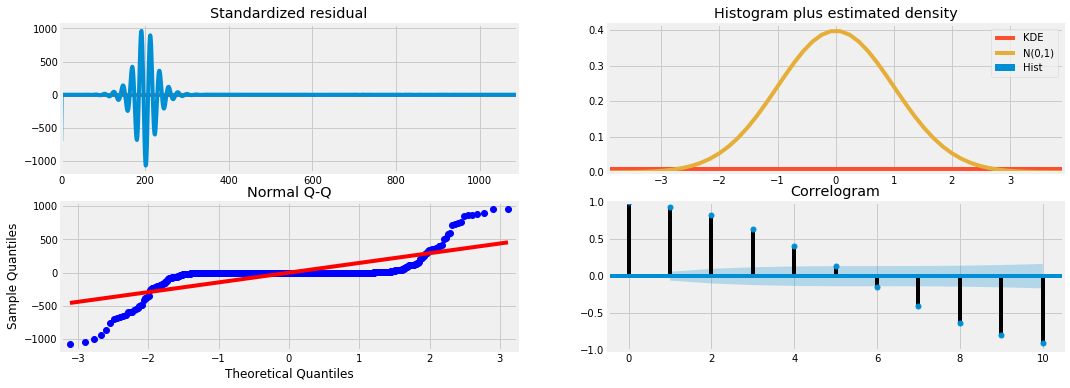

In [126]:
%%time
train_sample = eth["Volume"].diff().iloc[1:].values
model = sm.tsa.SARIMAX(train_sample,order=(4,0,4),trend='c', enforce_invertibility=False, enforce_stationarity=False)
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

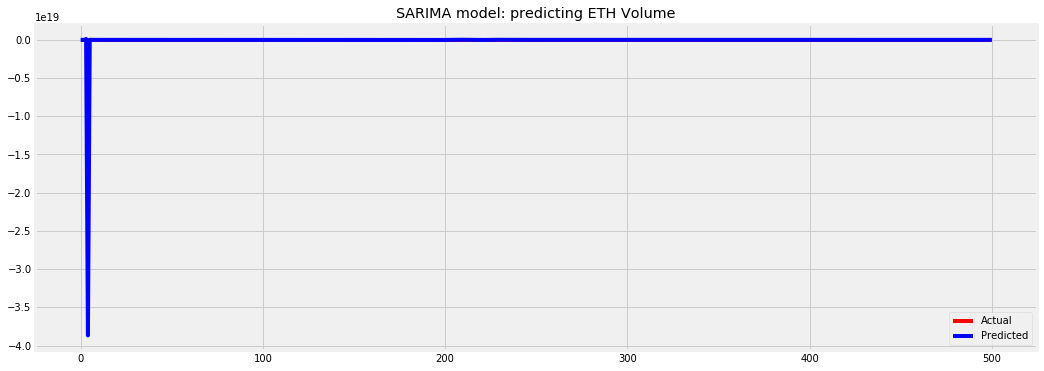

In [127]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('SARIMA model: predicting ETH Volume')
plt.show()

## <a id='4.6.2'>4.6.2 Unobserved components</a>
A UCM decomposes the response series into components such as trend, seasons, cycles, and the regression effects due to predictor series. The following model shows a possible scenario:
<img src="http://support.sas.com/documentation/cdl/en/etsug/66840/HTML/default/images/etsug_ucm0134.png">
Source: [http://support.sas.com/documentation/cdl/en/etsug/66840/HTML/default/viewer.htm#etsug_ucm_details01.htm](http://support.sas.com/documentation/cdl/en/etsug/66840/HTML/default/viewer.htm#etsug_ucm_details01.htm)

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                 1095
Model:                    local level   Log Likelihood               -9271.741
Date:                Wed, 02 Feb 2022   AIC                          18547.483
Time:                        08:44:33   BIC                          18557.480
Sample:                             0   HQIC                         18551.265
                               - 1095                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular   1.34e+06    2.6e+04     51.466      0.000    1.29e+06    1.39e+06
sigma2.level         0.0271      9.208      0.003      0.998     -18.019      18.074
Ljung-Box (Q):              

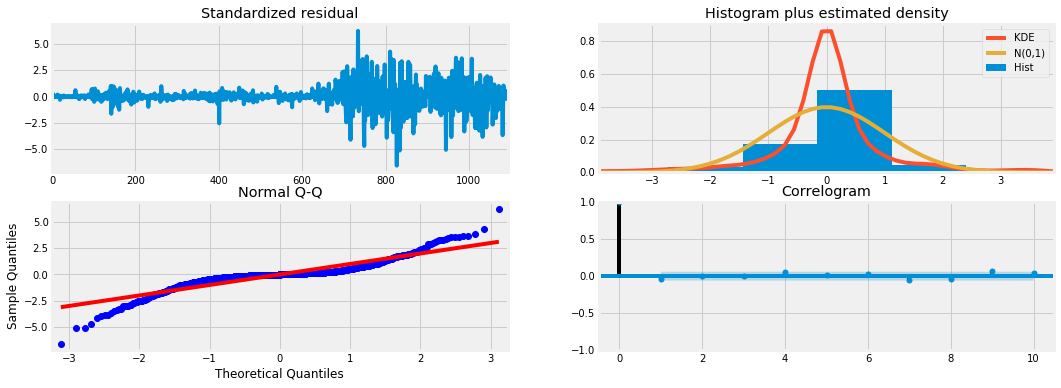

In [128]:
%%time
# Predicting closing price of BTC'
train_sample = btc["Close"].diff().iloc[1:].values
model = sm.tsa.UnobservedComponents(train_sample,'local level')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

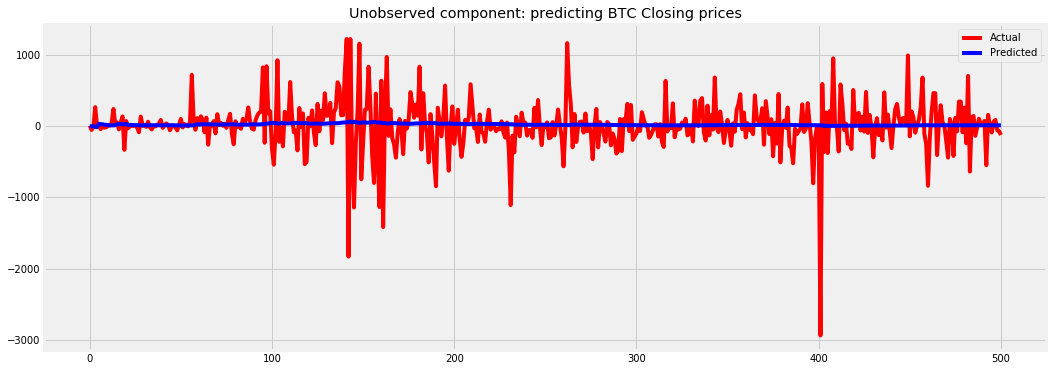

In [129]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('Unobserved component: predicting BTC Closing prices')
plt.show()

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                 1095
Model:                    local level   Log Likelihood              -27253.760
Date:                Wed, 02 Feb 2022   AIC                          54511.520
Time:                        08:44:35   BIC                          54521.517
Sample:                             0   HQIC                         54515.302
                               - 1095                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  2.461e+20   9.44e+17    260.525      0.000    2.44e+20    2.48e+20
sigma2.level      2.421e+17    7.7e+16      3.143      0.002    9.12e+16    3.93e+17
Ljung-Box (Q):              

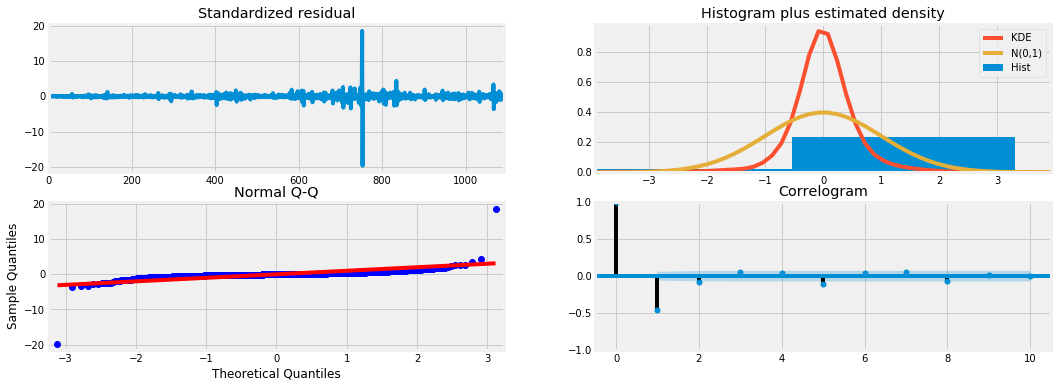

In [130]:
%%time
# Predicting Volume of BTC'
train_sample = btc["Volume"].diff().iloc[1:].values
model = sm.tsa.UnobservedComponents(train_sample,'local level')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

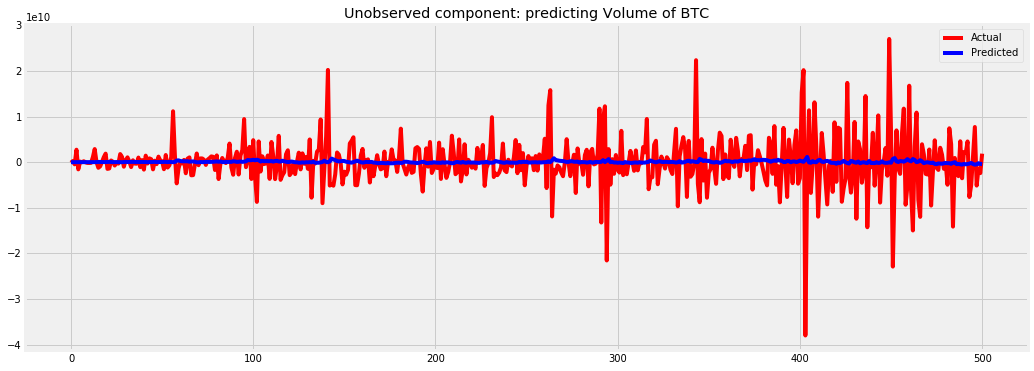

In [131]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('Unobserved component: predicting Volume of BTC')
plt.show()

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                 1095
Model:                    local level   Log Likelihood               -6472.255
Date:                Wed, 02 Feb 2022   AIC                          12948.510
Time:                        08:44:36   BIC                          12958.507
Sample:                             0   HQIC                         12952.292
                               - 1095                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  8006.5037    113.150     70.760      0.000    7784.733    8228.275
sigma2.level      2.953e-09      0.044   6.68e-08      1.000      -0.087       0.087
Ljung-Box (Q):              

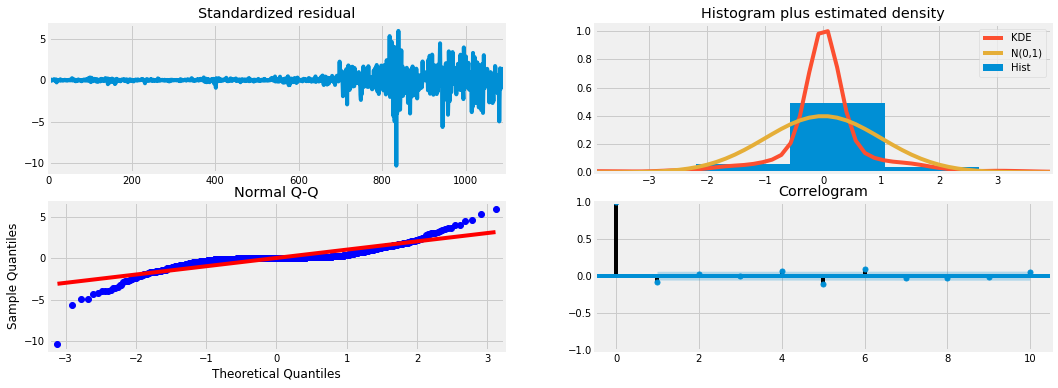

In [132]:
%%time
# Predicting closing price of ETH'
train_sample = eth["Close"].diff().iloc[1:].values
model = sm.tsa.UnobservedComponents(train_sample,'local level')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

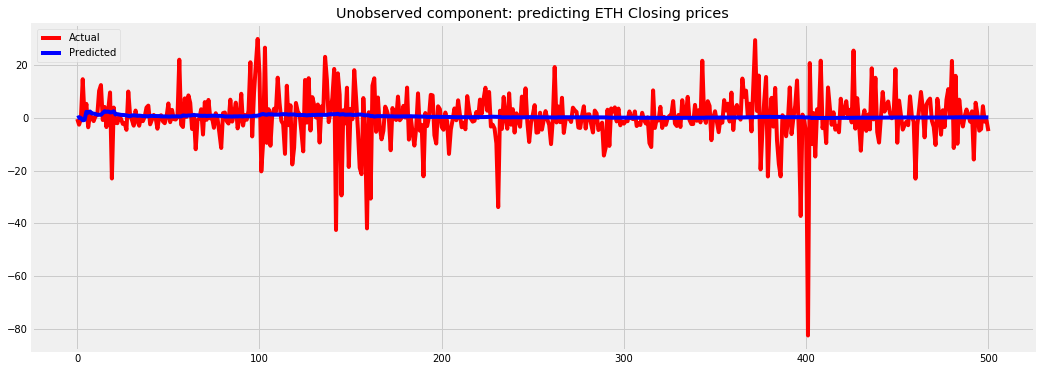

In [133]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('Unobserved component: predicting ETH Closing prices')
plt.show()

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                 1095
Model:                    local level   Log Likelihood              -25968.103
Date:                Wed, 02 Feb 2022   AIC                          51940.206
Time:                        08:44:37   BIC                          51950.203
Sample:                             0   HQIC                         51943.989
                               - 1095                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  2.254e+19   3.58e+17     62.888      0.000    2.18e+19    2.32e+19
sigma2.level      1.107e+17   5.48e+16      2.021      0.043    3.33e+15    2.18e+17
Ljung-Box (Q):              

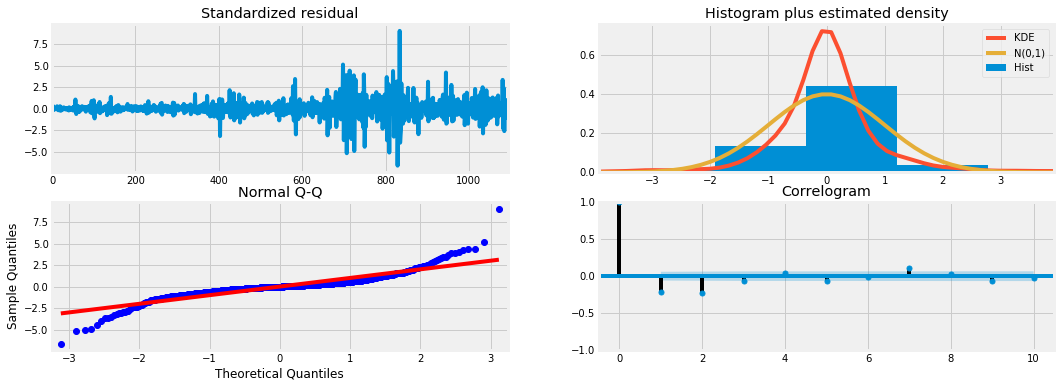

In [134]:
%%time
# Predicting Volume of ETH'
train_sample = eth["Volume"].diff().iloc[1:].values
model = sm.tsa.UnobservedComponents(train_sample,'local level')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

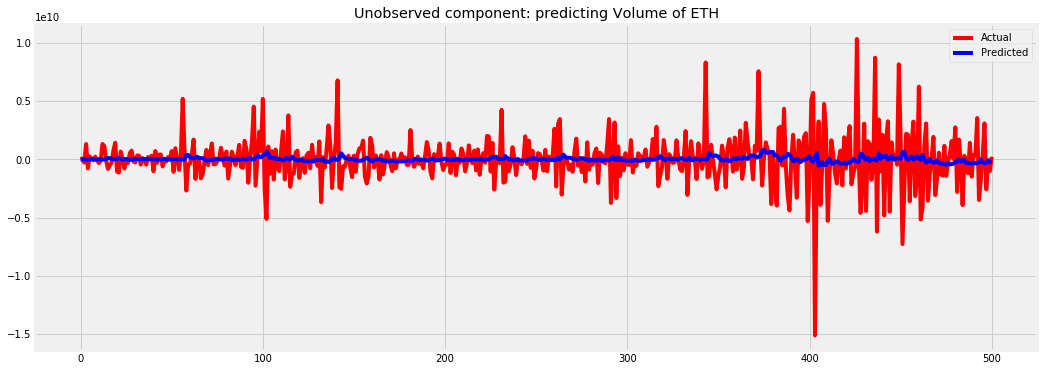

In [135]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('Unobserved component: predicting Volume of ETH')
plt.show()

## <a id='4.6.3'>4.6.3 Dynamic Factor models</a>
Dynamic-factor models are flexible models for multivariate time series in which the observed endogenous variables are linear functions of exogenous covariates and unobserved factors, which have a vector autoregressive structure. The unobserved factors may also be a function of exogenous covariates. The disturbances in the equations for the dependent variables may be autocorrelated.

In [136]:
def extract_subset(full_dataset: pd.DataFrame, percentage_to_extract: float = 0.10) -> pd.DataFrame:
    print(f'Before taking a sample: {full_dataset.shape}')
    subset_size = int(full_dataset.shape[0] * percentage_to_extract)
    result = full_dataset[-subset_size:].copy()
    print(f'After taking a sample: {result.shape}')
    return result

In [137]:
percentage_to_extract = 0.005

In [138]:
del btc
btc = extract_subset(btc_full, percentage_to_extract)

Before taking a sample: (1096, 5)
After taking a sample: (5, 5)


In [139]:
del eth
eth = extract_subset(eth_full, percentage_to_extract)

Before taking a sample: (1096, 5)
After taking a sample: (5, 5)


In [140]:
gc.collect()

78138

In [141]:
%%time
##### Currently throws an error, hence disabled: LinAlgError: Singular forecast error covariance matrix encountered at period 1 or period 0
# Predicting closing price of BTC and ETH
# train_sample = pd.concat([btc["Close"].diff().iloc[1:], eth["Close"].diff().iloc[1:]],axis=1)
# train_sample = train_sample.fillna(0.0) # Ideally we should not need to do this
# model = sm.tsa.DynamicFactor(train_sample, k_factors=1, factor_order=2)
# result = model.fit(maxiter=1000, disp=False)
# print(result.summary())
# predicted_result = result.predict(start=0, end=1000)
# result.plot_diagnostics()
# # calculating error
# rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
# print("The root mean squared error is {}.".format(rmse))

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.87 µs


In [142]:
# predicted_result.columns=['BTC Prediction', 'ETH Prediction']

In [143]:
# plt.plot(btc["Close"].diff().iloc[1:1000])
# plt.plot(predicted_result['BTC Prediction'])
# plt.legend(['Actual','Predicted'])
# plt.title('Dynamic Factor models: predicting BTC Closing prices')
# plt.show()

In [144]:
# plt.plot(eth["Close"].diff().iloc[1:1000])
# plt.plot(predicted_result['ETH Prediction'])
# plt.legend(['Actual','Predicted'])
# plt.title('Dynamic Factor models: predicting ETH Closing prices')
# plt.show()

In [145]:
# %%time
##### Currently throws an error, hence disabled: LinAlgError: Singular forecast error covariance matrix encountered at period 0
# # Predicting Volume of BTC and ETH
# train_sample = pd.concat([btc["Volume"].diff().iloc[1:], eth["Volume"].diff().iloc[1:]],axis=1)
# train_sample = train_sample.fillna(0.0) # Ideally we should not need to do this
# model = sm.tsa.DynamicFactor(train_sample, k_factors=1, factor_order=2)
# result = model.fit(maxiter=1000, disp=False)
# print(result.summary())
# predicted_result = result.predict(start=0, end=1000)
# result.plot_diagnostics()
# # calculating error
# rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
# print("The root mean squared error is {}.".format(rmse))

In [146]:
# predicted_result.columns=['BTC Prediction', 'ETH Prediction']

In [147]:
# plt.plot(btc["Volume"].diff().iloc[1:1000])
# plt.plot(predicted_result['BTC Prediction'])
# plt.legend(['Actual','Predicted'])
# plt.title('Dynamic Factor models: predicting Volume of BTC')
# plt.show()

In [148]:
# plt.plot(eth["Volume"].diff().iloc[1:1000])
# plt.plot(predicted_result['ETH Prediction'])
# plt.legend(['Actual','Predicted'])
# plt.title('Dynamic Factor models: predicting Volume of ETH')
# plt.show()

I may add more regression models soon and there is much more stuff to cover. **But in my experience, the best models for time series forecasting are LSTM based Recurrent Neural Networks. I have prepared a detailed tutorial for that. Here is the link: <u>https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru</u>**

References and influences (these have more in-depth content and explanations): 
* [Manipulating Time Series Data in Python](https://www.datacamp.com/courses/manipulating-time-series-data-in-python)
* [Introduction to Time Series Analysis in Python](https://www.datacamp.com/courses/introduction-to-time-series-analysis-in-python)
* [Visualizing Time Series Data in Python](https://www.datacamp.com/courses/visualizing-time-series-data-in-python)
* [VAR models and LSTM](https://www.youtube.com/watch?v=_vQ0W_qXMxk)
* [State space models](https://www.statsmodels.org/dev/statespace.html)
* [Awesome AI-ML-DL: Time-series / anomaly detection](https://github.com/neomatrix369/awesome-ai-ml-dl/tree/master/time-series_anomaly-detection)

Stay tuned for more! And don't forget to upvote and comment.